# Earthquake Data Analysis

The project consists of analyzing a dataset (called also "catalog") of earthquakes collected in about 20 years of recording in South California.

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* __Waiting time (t)__: time interval between an event and the next one in the sequence.
* __Distance (r)__: Euclidean 3D distance between events (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake).

## Data

The catalog `SouthCalifornia-1982-2011.dat` is a data file with the following content:

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (in meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

By joining each event to that with the index of the second column (if not -1), a set of causal trees would emerge.


## Assignments

1. Visualize the process in space and/or time with a suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or an appropriate linear combination of coordinates) as a function of time.
2. Compute the distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$. If deemed appropriate, choose a function and fit it to the data.
3. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude $m$ or above. Make a clever choice for the bin sizes, and try several values of $m$. Fit the data with an appropriate function, if possible.
4. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. In this case, if the following event is farther than $R$, skip the $t$ and go to the next pair.
5. Comment whether there is a scaling law from the analysis of the previous points. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats

--------------------------------------

1. Visualize the process in space and/or time with a suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or an appropriate linear combination of coordinates) as a function of time.

-------------------------------------

---------------------------------

2. Compute the distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$. If deemed appropriate, choose a function and fit it to the data.

------------------------------------

## The Power Law

The power law is an important mathematical relationship used to describe phenomena exhibiting scale invariance, where the frequency of an event decreases very slowly as the size of that event increases.

This law is expressed by the following relationship:

$$ P_m(t) = a \cdot t^{-k} $$

where:

- $ a $ is a constant of proportionality.
- $ k $ is a negative constant, known as the exponent or degree of the law.

### Graphical Representation

The key characteristic of the power law is its representation in logarithmic coordinates.

By plotting the logarithm of each side of the equation, we obtain a linear relationship:

$$ \log(P_m(t)) = \log(a) - k\log(t) $$

By setting $ X = \log(t) $ and $ Y = \log(P_m(t)) $, this equation can be rewritten in the form of a linear equation:

$$ Y = -kX + \log(a) $$

where the slope of the line is the exponent $ k $ and the y-intercept is $ \log(a) $.

This linear representation in logarithmic coordinates is useful for identifying and analyzing phenomena that obey a power law, as it simplifies the visualization and interpretation of data that might otherwise seem complex or disordered.

Seismic events exhibit complex spatial and temporal characteristics, yet they conform to certain straightforward statistical laws. Notably, the intervals between earthquakes and their spatial distribution tend to adhere to a power law, expressed as P(t)=Ct−αP(t)=Ct−α. This suggests a predictable pattern in the occurrence of earthquakes. On a log-log graph, this power law behavior is depicted as a linear relationship, formulated as ln⁡P(t)=ln⁡C−αln⁡tlnP(t)=lnC−αlnt, demonstrating a regularity in the statistical nature of seismic activities.

### Summary

Although earthquakes exhibit complex spatial and temporal characteristics, they follow predictable statistical patterns. They adhere to a power law, represented by $ P_m(t) = a \cdot t^{-k} $, indicating a degree of predictability in their occurrence. 

By converting these data into logarithmic scales using a log-log plot, the values for the power law can be efficiently extracted. This transformation reveals that the power law corresponds to a linear relationship, expressed as \$ \log(P_m(t)) = \log(a) - k\log(t) $. 

This linearity in a log-log plot underscores the regularity and predictability in the statistical nature of seismic activities.


In [3]:
def power_law(t, a, k):
    """
    Computes the power law function.

    :param t: The time variable for the power law equation.
    :param a: The scaling factor in the power law equation.
    :param k: The exponent in the power law equation.
    :return: The computed value of the power law function.
    """
    return a * (t ** (-k))

In [4]:
def linear(t, a, b):
    """
    Computes the linear function.

    :param t: The independent variable.
    :param a: The slope of the linear function.
    :param b: The y-intercept of the linear function.
    :return: The computed value of the linear function for the given x.
    """
    return a * t + b

## Initialization

First, we load the dataset we're going to use for this part. 

In [23]:
def load_dataset():
    """
    Load the dataset from a CSV file, set column names, and sort by Time.

    :return: A DataFrame containing the loaded and sorted dataset.
    """
    names = ['Event_index', 'Previous_event', 'Time', 'Magnitude', 'x', 'y', 'z']
    df = pd.read_csv('SouthCalifornia-1982-2011.dat', sep=' ', names=names)
    df = df.sort_values(by=['Time'])
    return df

df = load_dataset()

We define m, which corresponds to the different earthquake magnitudes we'll study in this section, as: m = [2, 3, 4, 5].

In [24]:
m = [i for i in range(2,6)]

In this exercise, we analyze the waiting time distribution for earthquakes, focusing on events with magnitudes in the range of 2 to 5. We filter our dataset for earthquakes above each magnitude threshold and compute the waiting times as the intervals between consecutive events.

This analysis, starting from a magnitude of 2 and extending to other values, aims to understand the temporal patterns and dynamics of seismic activities based on their magnitudes.

## TEST FOR M = 2

In [25]:
m2 = m[0]

In our context, we need to filter our dataset to retain only values greater than or equal to the specified minimum magnitude, in this case m = 2. 

In addition, we need to add a column entitled "Waiting Time", which will calculate waiting times as the intervals between consecutive seismic events.

In [26]:
def dataframe_process(df, magnitude_threshold):
    """
    Filters the earthquakes in the DataFrame 'df' for those with a magnitude of 'magnitude_threshold' or higher,
    and calculates the waiting times (intervals) between consecutive events.

    :param df: DataFrame containing the earthquake data.
    :param magnitude_threshold: Minimum magnitude of earthquakes to consider.
    :return: DataFrame filtered with calculated waiting times.
    """
    # Filter earthquakes with magnitude magnitude_threshold or higher
    df_filtered = df[df['Magnitude'] >= magnitude_threshold].copy()

    print(f"Number of earthquakes selected for magnitude = {magnitude_threshold} : {df_filtered.shape[0]}")

    # Calculate the waiting time as the interval between events
    df_filtered['Waiting Time'] = df_filtered['Time'].diff(-1).abs()

    # Remove missing values, if any
    df_filtered.dropna(inplace=True)

    return df_filtered

In [27]:
# Applying the function to process the dataset for m = 2
df_m2 = dataframe_process(df, m2)
print(f"Processed dataset for magnitude = {m2}:\n\n{df_m2}")

Number of earthquakes selected for magnitude = 2 : 110271
Processed dataset for magnitude = 2:

        Event_index  Previous_event          Time  Magnitude        x  \
0                 0              -1  0.000000e+00       2.71 -2571956   
1                 1               0  3.650139e+04       2.12 -2363740   
2                 2               0  3.748828e+04       2.33 -2363746   
3                 3               0  4.798252e+04       2.57 -2475085   
4                 4               0  6.026857e+04       2.98 -2238642   
...             ...             ...           ...        ...      ...   
110265       110265          110250  9.304962e+08       2.08 -2365328   
110266       110266              -1  9.304996e+08       2.60 -2668492   
110267       110267              -1  9.305115e+08       2.02 -2297480   
110268       110268              -1  9.305318e+08       2.00 -2404797   
110269       110269              -1  9.305363e+08       2.17 -2388375   

              y        z  W

## Seismic Waiting Times Analysis

In this analysis, we aim to explore and understand the frequency distribution of waiting times between seismic events. 

Our approach involves two main stages: histogram visualization and distribution analysis.


### Histogram Visualization
First, we will create a histogram to visually represent the frequency of seismic waiting times. To achieve an effective binning strategy, we will use a fixed bin size determined by the square root of the total number of events, denoted as $ \sqrt{N_m} $, where $ N_m $ represents the total count of seismic events.

So, each bin in the histogram will be associated with a Poisson uncertainty, calculated using the formula $ \theta_m = \sqrt{N_m} $. Here, $ N_m $ is the count of events in each bin. This uncertainty quantifies the statistical error inherent in the event counts, allowing us to understand the reliability and variation of the data in each bin.

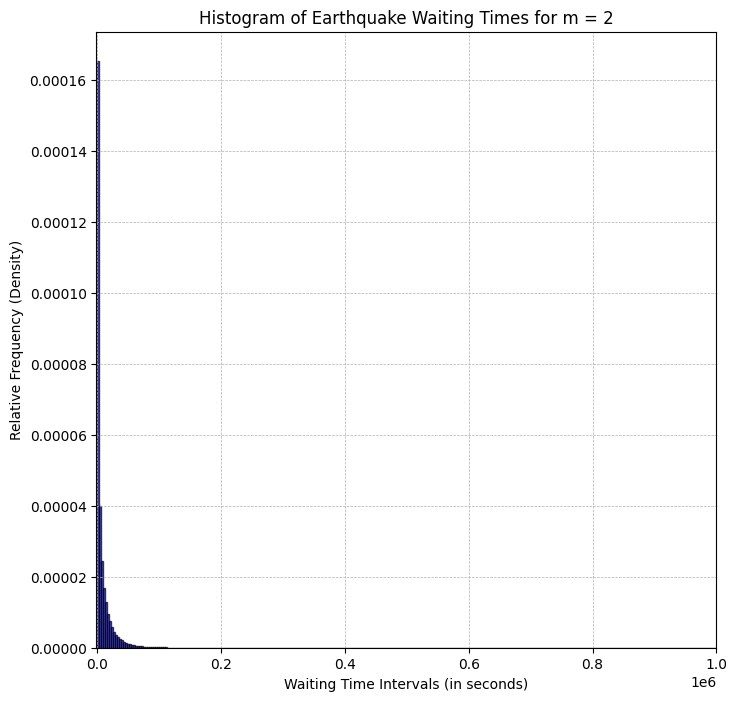

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

# Determine the number of bins for the histogram
bin_edges = int(np.sqrt(df_m2.shape[0]))

# Plot the histogram of waiting times
# df_m2['Waiting Time'] contains the intervals between earthquakes, and is plotted with a specified number of bins
h_m2, bins_m2, _ = ax.hist(df_m2['Waiting Time'], bins=bin_edges, color='blue', alpha=0.7, density=True, edgecolor='black')

ax.set_xlim(-1000, 1000000)
ax.set_title(f'Histogram of Earthquake Waiting Times for m = {m2}')
ax.set_xlabel('Waiting Time Intervals (in seconds)')
ax.set_ylabel('Relative Frequency (Density)')

ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()


The graph above illustrates the profile of a power law with exponential behavior.

### Distribution Analysis
After viewing the histogram, we will analyze the distribution of waiting times in more detail. We plot the histogram in log-log scale

This part of the analysis aims to discover and highlight the linear model which defines our power law, in order to understand seismic processes.

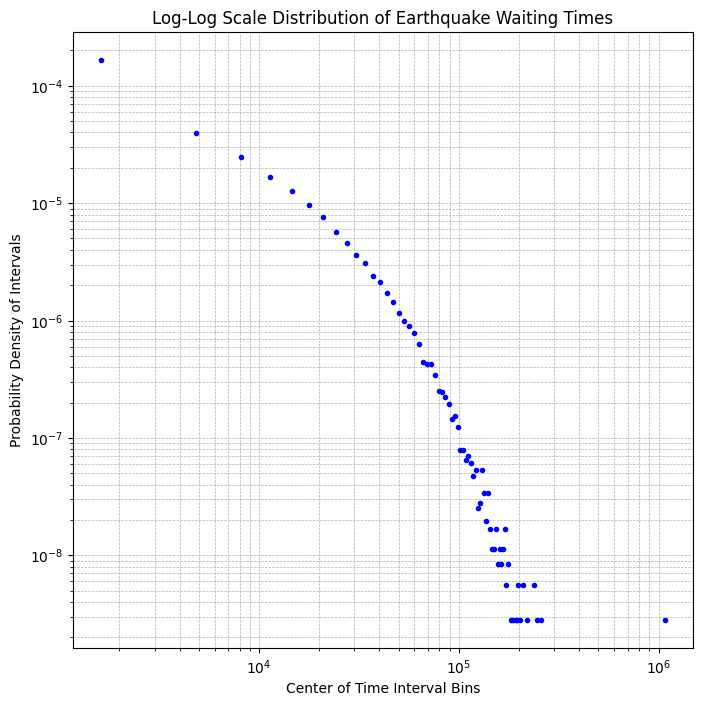

In [29]:
# Calculate the centers of the bins for plotting
bin_centers = (bins_m2[:-1] + bins_m2[1:]) / 2

fig, ax = plt.subplots(figsize=(8, 8))

# Set both the x and y axes to logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')

# Plot the data points
ax.plot(bin_centers, h_m2, 'b.')

ax.set_title('Log-Log Scale Distribution of Earthquake Waiting Times')
ax.set_xlabel('Center of Time Interval Bins')
ax.set_ylabel('Probability Density of Intervals')

ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()


We observe noise in the tail of the distribution due to the low number of entries in this region. 

As mentioned earlier, assuming power-law behavior, we would need to perform a linear regression on the log-log histogram data to extrapolate the parameters of the distribution. However, noise introduces a bias on the slope. 

To remove this noise, we need to increase the size of the bins in the tail of the distribution.
So, we can therefore use the logarithmic bins.

## Logarithmic Binning

As explained later, in order to eliminate noise from the data, we will calculate the histogram using logarithmic binning.

In this context, the process involves using logarithmic binning to create a histogram.

Logarithmic binning is a technique where bin sizes increase exponentially as you move along the axis, typically used for dealing with distributions with long tails.

So, instead of using equally spaced bins, we opt for logarithmic binning. This means that bin sizes increase exponentially. Each bin represents a specific range of values, but the width of these bins increases as you progress along the axis.

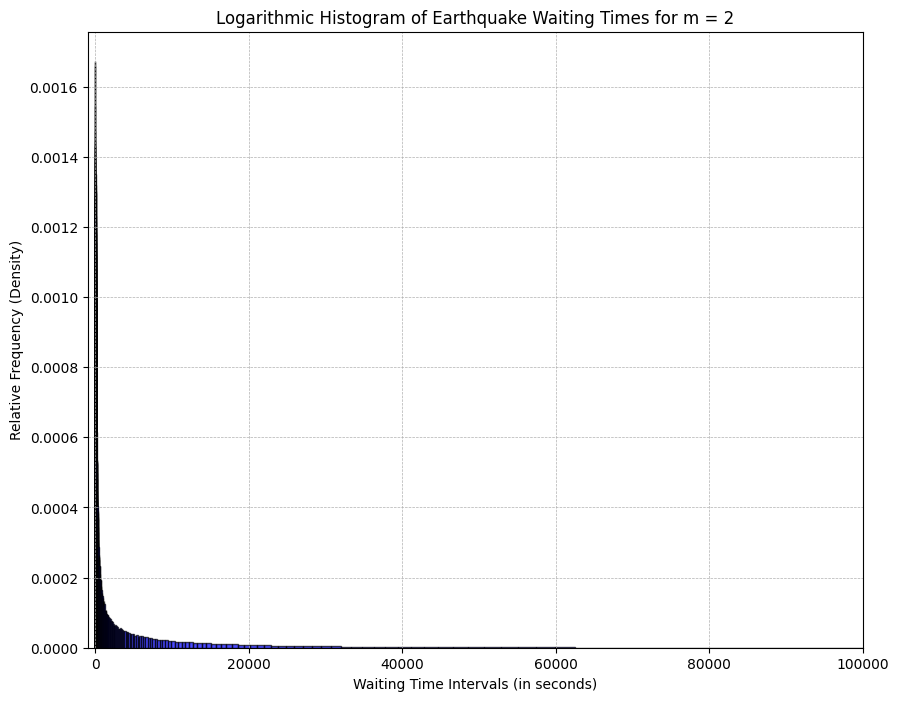

In [30]:
# Calculate logarithmic bins for histogram, suitable for data covering wide value ranges.
bin_edges = np.logspace(0, np.log10(df_m2['Waiting Time'].max()), int(np.sqrt(df_m2.shape[0])) + 1)

# Create a normalized histogram with logarithmic bins. Normalization helps in comparing distributions.
fig, ax = plt.subplots(figsize=(10, 8))

_, bins, _ = ax.hist(df_m2['Waiting Time'], bins=bin_edges, color='blue', alpha=0.7, density=True, edgecolor='black')

ax.set_xlim(-1000, 100000)
ax.set_title(f'Logarithmic Histogram of Earthquake Waiting Times for m = {m2}')
ax.set_xlabel('Waiting Time Intervals (in seconds)')
ax.set_ylabel('Relative Frequency (Density)')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

We now plot the histogram in logarithmic scale, using logarithmic binning.

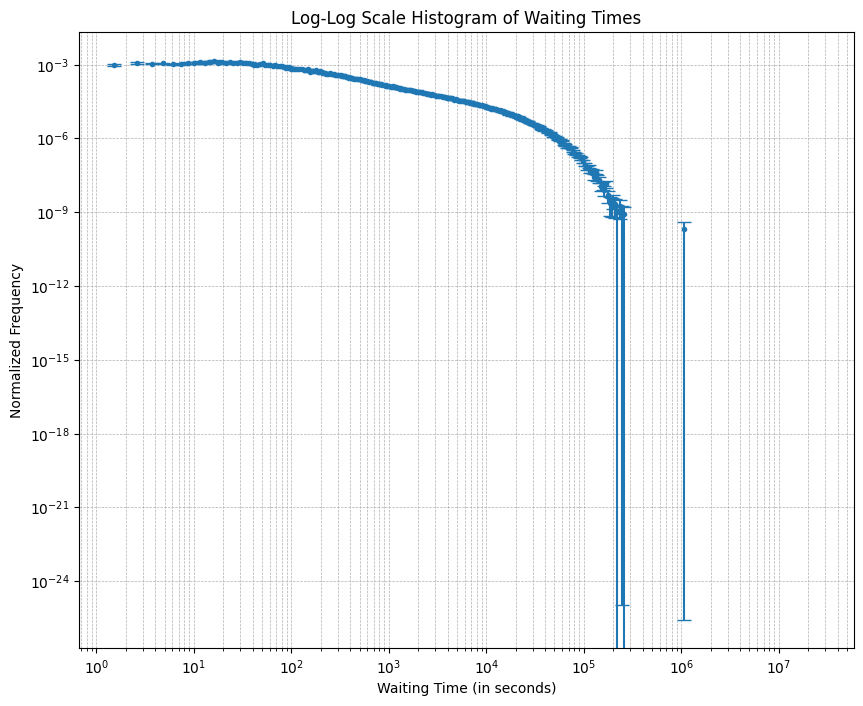

In [31]:
# Calculate logarithmic bin edges by summing the specified bin widths.
edges = np.cumsum(bin_edges)

# Create a non-normalized histogram to compute errors for each bin.
fig, ax = plt.subplots(figsize=(10, 8))
counts, bins, _ = ax.hist(df_m2['Waiting Time'], bins=edges, density=False)
plt.close()

# Compute errors as the square root of counts (Poissonian statistics) and normalize.
bin_widths = np.diff(bins)
y_error = np.divide(np.sqrt(counts), counts.sum() * bin_widths)

# Calculate the center of each bin for plotting.
bin_centers = (bins[1:] + bins[:-1]) / 2

# Create a normalized histogram to obtain frequency data.
fig, ax = plt.subplots(figsize=(10, 8))
counts_normalized, _, _ = ax.hist(df_m2['Waiting Time'], bins=edges, density=True, edgecolor='black')
plt.close()

# Plot a dot histogram with error bars representing the normalized frequency.
fig, ax = plt.subplots(figsize=(10, 8))

ax.errorbar(bin_centers, counts_normalized, yerr=y_error, fmt='.', capsize=5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Log-Log Scale Histogram of Waiting Times')
ax.set_xlabel('Waiting Time (in seconds)')
ax.set_ylabel('Normalized Frequency')

ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

Thanks to logarithmic binning, the visualization of variations and statistical errors, especially in regions of the distribution where data is less dense, is facilitated.

As a result, logarithmic binning allows for a better visualization of the data distribution on a log-log scale graph. This makes variations and statistical uncertainties more apparent, particularly in the tails of the distribution where data is less frequent.

By visualizing the data in this way, it becomes easier to identify points that stand out as outliers or points influenced by noise. These points may be candidates for removal or correction if necessary.

In our case, these data points with significant errors are the ones we need to eliminate in order to determine the parameters of our power law.

## Optimization of Linear Regression for Estimating $a$ and $k$ in a Power Law Distribution

### Context and Challenges
Power law distributions are characterized by a linear relationship when plotted on a log-log graph. However, in real data sets, this linearity is often confined to a specific range. Outside this range, various factors such as limited sample size and statistical noise can cause deviations from this linearity.

### Objective
Our goal is to accurately estimate $a$, the coefficient of proportionality, and $k$, the exponent of the power law. To achieve this, it is crucial to focus on the linear part of the distribution, defining a range of data that adheres to the expected linear behavior.

### Methodology
1. **Data Filtering**: We note that as waiting times increase, there is a loss of linearity in the log-log distribution. To address this, we adopt an iterative approach to remove outliers or non-linear data, one at a time.

2. **Segment-wise Linear Regression**: In each iteration, we perform linear regression on the remaining data segments. The aim is to determine the best straight line that fits the log-log plot, where the slope reveals both the exponent $k$ and the coefficient $a$ of the power law.

3. **Selection Criterion Based on R²**: The coefficient of determination R² serves as the primary criterion for identifying the optimal lower limit. A high R² (e.g., ≥ 0.95) indicates a reliable fit while retaining a sufficient number of data points. This approach allows us to isolate the portion of the distribution that best follows a linear behavior in log-log scale.

### Expected Outcomes
By following this method, we can extract accurate estimates for $a$ and $k$, faithfully reflecting the characteristics of the power law in our data. This rigorous approach ensures that our results are robust, reliable, and representative of the linear part of the distribution, thus providing a clear and precise interpretation of the power law in the context of our study.


R^2: 0.76, with 222 data points remaining
R^2: 0.76, with 221 data points remaining
R^2: 0.77, with 220 data points remaining
R^2: 0.77, with 219 data points remaining
R^2: 0.78, with 218 data points remaining
R^2: 0.78, with 217 data points remaining
R^2: 0.79, with 216 data points remaining
R^2: 0.79, with 215 data points remaining
R^2: 0.80, with 214 data points remaining
R^2: 0.81, with 213 data points remaining
R^2: 0.81, with 212 data points remaining
R^2: 0.82, with 211 data points remaining
R^2: 0.82, with 210 data points remaining
R^2: 0.83, with 209 data points remaining
R^2: 0.83, with 208 data points remaining
R^2: 0.84, with 207 data points remaining
R^2: 0.84, with 206 data points remaining
R^2: 0.84, with 205 data points remaining
R^2: 0.85, with 204 data points remaining
R^2: 0.85, with 203 data points remaining
R^2: 0.86, with 202 data points remaining
R^2: 0.86, with 201 data points remaining
R^2: 0.87, with 200 data points remaining
R^2: 0.87, with 199 data points re

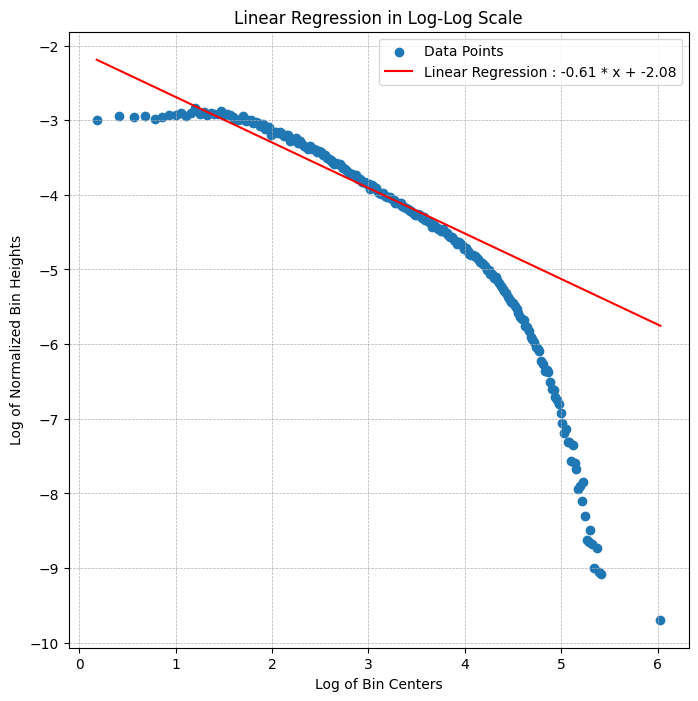


Best-fit parameters:
	 - Slope       : -0.61
	 - Intercept   : -2.08



In [32]:
# Data initialization
x = np.array(bin_centers)  # Array of bin center data
y = np.array(counts_normalized)  # Array of normalized count data
errors = np.sqrt(y)  # Calculation of errors, assuming Poisson statistics

# Removing zero values to avoid issues with logarithmic scaling
zero_or_not = (y != 0)
x = x[zero_or_not]
y = y[zero_or_not]
errors = errors[zero_or_not]

# Loop to iteratively remove values and calculate R^2 for assessing fit quality
prev_r_squared = -np.inf  # Initialize previous R^2 to negative infinity
prev_popt = -np.inf
prev_pcov = -np.inf
for i in range(len(x), 0, -1):
    try:
        # Perform linear fitting in log-log scale
        popt, pcov = optimize.curve_fit(linear, np.log10(x[:i]), np.log10(y[:i]), sigma=np.log10(errors[:i]), absolute_sigma=True)
        
        # Calculate R-squared to assess the fit
        r_squared = 1. - np.sum((np.log10(y[:i]) - linear(np.log10(x[:i]), *popt))**2) / np.sum((np.log10(y[:i]) - np.mean(np.log10(y[:i])))**2)
        print(f"R^2: {r_squared:.2f}, with {i} data points remaining")

        # Stop if R^2 decreases, indicating no further improvement
        if r_squared < prev_r_squared:
            print("R^2 is lower than previous value. Stopping removal of data points and returns to the previous data.")
            popt = prev_popt
            pcov = prev_pcov
            break
        prev_r_squared = r_squared
        prev_popt = popt
        prev_pcov = pcov

    except Exception as e:
        print(f"Error in fitting: {e}")
        continue

# Plotting the results
slope, intercept = popt  # Extract fitting parameters

xax = np.linspace(min(np.log10(x)), max(np.log10(x)), 1000)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(np.log10(x), np.log10(y), label='Data Points')  # Plot data points
ax.plot(xax, linear(xax, *popt), color='red', label=f'Linear Regression : {slope:.2f} * x + {intercept:.2f}')  # Plot linear fit

ax.set_title('Linear Regression in Log-Log Scale')
ax.set_xlabel('Log of Bin Centers')
ax.set_ylabel('Log of Normalized Bin Heights')

ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

# Best-fit parameters
print(f"""
Best-fit parameters:
\t - Slope       : {slope:.2f}
\t - Intercept   : {intercept:.2f}
""")

We will now apply the estimated values of $a$, the coefficient of proportionality, and $k$, the exponent of the power law, to determine if the obtained model fits well with the estimated values.

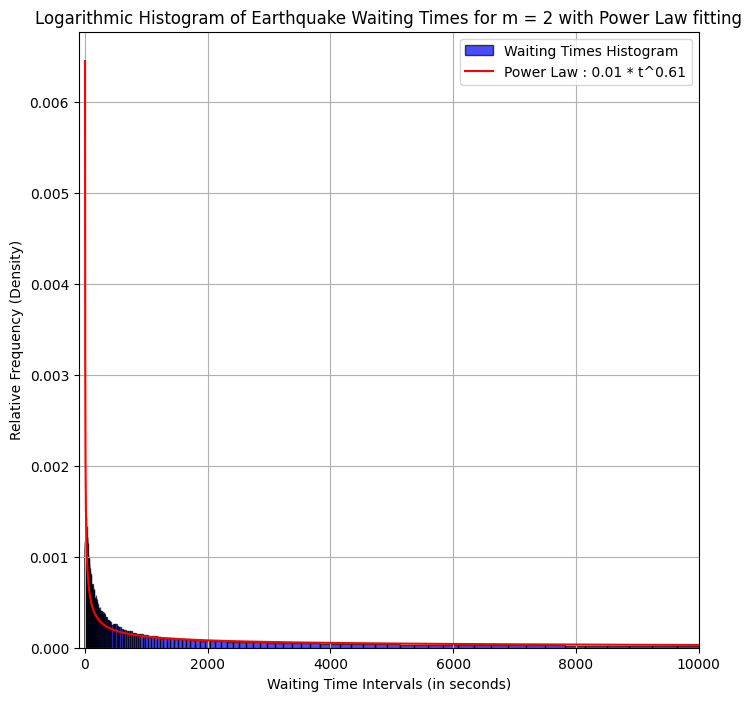

In [33]:
# Creating a plot for the distribution of waiting times
fig, ax = plt.subplots(figsize=(8,8))  # Initialize a figure with specific size

# Histogram of waiting times
h_m2, bins_m2, _ = ax.hist(df_m2['Waiting Time'], bins=edges, color='blue', alpha = 0.7, density=True, edgecolor='black', label='Waiting Times Histogram')

# Power Law Plot
ax.plot(x, power_law(x, 10**intercept, -slope), color='red', label=f'Power Law : {10**intercept:.2f} * t^{-slope:.2f}')

ax.set_xlim(-100, 10000)
ax.set_title(f'Logarithmic Histogram of Earthquake Waiting Times for m = {m2} with Power Law fitting')
ax.set_xlabel('Waiting Time Intervals (in seconds)')
ax.set_ylabel('Relative Frequency (Density)')

ax.legend()
ax.grid()

# Display the plot
plt.show()

In [34]:
def chi_squared_test(x, y_observed, y_predicted, alpha=0.05):
    """
    Perform a chi-squared test and return the test result.

    Args:
    - x : numpy array of x values.
    - y_observed : numpy array of observed values.
    - y_predicted : numpy array of values predicted by the model.
    - alpha : significance threshold for the chi-squared test (default is 0.05).

    Returns:
    - chi_squared_statistic : Chi-squared test statistic.
    - p_value : p-value of the chi-squared test.
    - significance : True if the model is significant (p < alpha), False otherwise.
    """

    # Calculate residuals
    residuals = y_observed - y_predicted

    # Calculate chi-squared residual
    chi_squared_residual = np.sum(residuals**2)

    # Degrees of freedom (number of data points - 2)
    degrees_of_freedom = len(x) - 2

    # Calculate the chi-squared test statistic
    chi_squared_statistic = chi_squared_residual / degrees_of_freedom

    # Calculate the p-value
    p_value = 1 - stats.chi2.cdf(chi_squared_statistic, degrees_of_freedom)

    # Evaluate statistical significance
    significance = p_value < alpha
    
    print(f"Chi-squared test statistic: {chi_squared_statistic:.2f}")
    print(f"P-value: {p_value:.4f}")
    if significance:
        print("The model is not a good fit for your data (p < alpha)")
    else:
        print("The model is a good fit for your data (p >= alpha)")

    return chi_squared_statistic, p_value, significance

chi_squared_statistic, p_value, significance = chi_squared_test(x, np.log10(y), np.log10(power_law(x, 10**intercept, -slope)))

Chi-squared test statistic: 1.09
P-value: 1.0000
The model is a good fit for your data (p >= alpha)


## TEST ON ALL VALUES OF m = [2, 5]

In [35]:
def process_earthquake_data(df, magnitude_thresholds):
    for magnitude_threshold in magnitude_thresholds:
        print(f"""\n\n
        #################################################################################################################
                                                        FOR m = {magnitude_threshold}
        #################################################################################################################
        \n\n""")
        
        # DataFrame processing for each magnitude
        df_processed = dataframe_process(df, magnitude_threshold)

        # Calculate logarithmic bins for histogram, suitable for data covering wide value ranges.
        bin_edges = np.logspace(0, np.log10(df_processed['Waiting Time'].max()), int(np.sqrt(df_processed.shape[0])) + 1)

        # Create a normalized histogram with logarithmic bins. Normalization helps in comparing distributions.
        fig, ax = plt.subplots(figsize=(8, 8))  # Create a subplot with two columns

        _, bins, _ = ax.hist(df_processed['Waiting Time'], bins=bin_edges, color='blue', alpha=0.7, density=True, edgecolor='black')

        ax.set_xlim(-1000, 100000)
        ax.set_title(f'Logarithmic Histogram of Earthquake Waiting Times for m = {magnitude_threshold}')
        ax.set_xlabel('Waiting Time Intervals (in seconds)')
        ax.set_ylabel('Relative Frequency (Density)')
        ax.grid(True, which="both", ls="--", linewidth=0.5)
        plt.show()
        
        # --------------------------------------------------------------------------------------------------------------
        
        # Calculate logarithmic bin edges by summing the specified bin widths.
        edges = np.cumsum(bin_edges)

        # Create a non-normalized histogram to compute errors for each bin.
        counts, bins, _ = plt.hist(df_m2['Waiting Time'], bins=edges, density=False)
        plt.close()

        # Compute errors as the square root of counts (Poissonian statistics) and normalize.
        bin_widths = np.diff(bins)
        y_error = np.divide(np.sqrt(counts), counts.sum() * bin_widths)

        # Calculate the center of each bin for plotting.
        bin_centers = (bins[1:] + bins[:-1]) / 2

        # Create a normalized histogram to obtain frequency data.
        counts_normalized, _, _ = plt.hist(df_m2['Waiting Time'], bins=edges, density=True, edgecolor='black')
        plt.close()
        
        # Plot a dot histogram with error bars representing the normalized frequency.
        fig, ax = plt.subplots(figsize=(8, 8))
        
        ax.errorbar(bin_centers, counts_normalized, yerr=y_error, fmt='.', capsize=5)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('Log-Log Scale Histogram of Waiting Times')
        ax.set_xlabel('Waiting Time (in seconds)')
        ax.set_ylabel('Normalized Frequency')
        ax.grid(True, which="both", ls="--", linewidth=0.5)
        plt.show()

        # --------------------------------------------------------------------------------------------------------------
        
        x = np.array(bin_centers)  # Array of bin center data
        y = np.array(counts_normalized)  # Array of normalized count data
        errors = np.sqrt(y)  # Calculation of errors, assuming Poisson statistics

        # Removing zero values to avoid issues with logarithmic scaling
        zero_or_not = (y != 0)
        x = x[zero_or_not]
        y = y[zero_or_not]
        errors = errors[zero_or_not]

        # Loop to iteratively remove values and calculate R^2 for assessing fit quality
        prev_r_squared = -np.inf  # Initialize previous R^2 to negative infinity
        prev_popt = -np.inf
        prev_pcov = -np.inf
        for i in range(len(x), 0, -1):
            try:
                # Perform linear fitting in log-log scale
                popt, pcov = optimize.curve_fit(linear, np.log10(x[:i]), np.log10(y[:i]), sigma=np.log10(errors[:i]), absolute_sigma=True)

                # Calculate R-squared to assess the fit
                r_squared = 1. - np.sum((np.log10(y[:i]) - linear(np.log10(x[:i]), *popt))**2) / np.sum((np.log10(y[:i]) - np.mean(np.log10(y[:i])))**2)
                print(f"R^2: {r_squared:.2f}, with {i} data points remaining")

                # Stop if R^2 decreases, indicating no further improvement
                if r_squared < prev_r_squared:
                    print("R^2 is lower than previous value. Stopping removal of data points and returns to the previous data.")
                    popt = prev_popt
                    pcov = prev_pcov
                    break
                prev_r_squared = r_squared
                prev_popt = popt
                prev_pcov = pcov
                
            except Exception as e:
                print(f"Error in fitting: {e}")
                continue

        slope, intercept = popt  # Extract fitting parameters
        xax = np.linspace(min(np.log10(x)), max(np.log10(x)), 1000)

        fig, ax = plt.subplots(2, 1, figsize=(8, 12))

        ax[0].scatter(np.log10(x), np.log10(y), label='Data Points')  # Plot data points
        ax[0].plot(xax, linear(xax, *popt), color='red', label=f'Linear Regression : {slope:.2f} * x + {intercept:.2f}')  # Plot linear fit

        ax[0].set_title('Linear Regression in Log-Log Scale')
        ax[0].set_xlabel('Log of Bin Centers')
        ax[0].set_ylabel('Log of Normalized Bin Heights')
        ax[0].legend()
        ax[0].grid(True, which="both", ls="--", linewidth=0.5)
  
        # Best-fit parameters
        print(f"""
        Best-fit parameters:
        \t - Slope       : {slope:.2f}
        \t - Intercept   : {intercept:.2f}
        """)

        # --------------------------------------------------------------------------------------------------------------
        
        # Creating a plot for the distribution of waiting times

        # Histogram of waiting times
        h, bins, _ = ax[1].hist(df_m2['Waiting Time'], bins=edges, color='blue', alpha=0.7, density=True, edgecolor='black', label='Waiting Times Histogram')
        # Power Law Plot
        ax[1].plot(x, power_law(x, 10**intercept, -slope), color='red', label=f'Power Law : {10**intercept:.2f} * t^{-slope:.2f}')

        ax[1].set_xlim(-100, 10000)
        ax[1].set_title(f'Logarithmic Histogram of Earthquake Waiting Times for m = {magnitude_threshold} with Power Law fitting')
        ax[1].set_xlabel('Waiting Time Intervals (in seconds)')
        ax[1].set_ylabel('Relative Frequency (Density)')
        ax[1].legend()
        ax[1].grid()
        plt.show()

        # Perform chi-squared test
        chi_squared_statistic, p_value, significance = chi_squared_test(x, np.log10(y), np.log10(power_law(x, 10**intercept, -slope)))




        #################################################################################################################
                                                        FOR m = 2
        #################################################################################################################
        


Number of earthquakes selected for magnitude = 2 : 110271


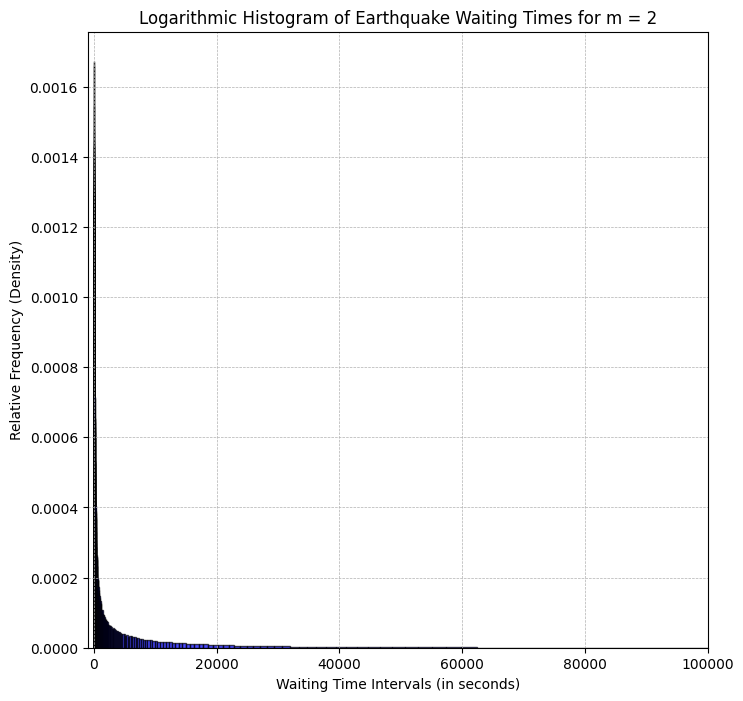

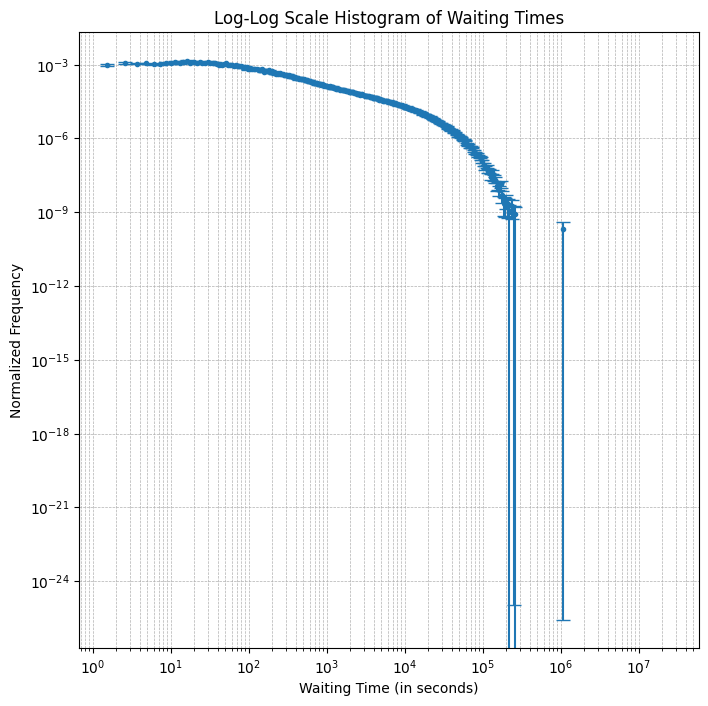

R^2: 0.76, with 222 data points remaining
R^2: 0.76, with 221 data points remaining
R^2: 0.77, with 220 data points remaining
R^2: 0.77, with 219 data points remaining
R^2: 0.78, with 218 data points remaining
R^2: 0.78, with 217 data points remaining
R^2: 0.79, with 216 data points remaining
R^2: 0.79, with 215 data points remaining
R^2: 0.80, with 214 data points remaining
R^2: 0.81, with 213 data points remaining
R^2: 0.81, with 212 data points remaining
R^2: 0.82, with 211 data points remaining
R^2: 0.82, with 210 data points remaining
R^2: 0.83, with 209 data points remaining
R^2: 0.83, with 208 data points remaining
R^2: 0.84, with 207 data points remaining
R^2: 0.84, with 206 data points remaining
R^2: 0.84, with 205 data points remaining
R^2: 0.85, with 204 data points remaining
R^2: 0.85, with 203 data points remaining
R^2: 0.86, with 202 data points remaining
R^2: 0.86, with 201 data points remaining
R^2: 0.87, with 200 data points remaining
R^2: 0.87, with 199 data points re

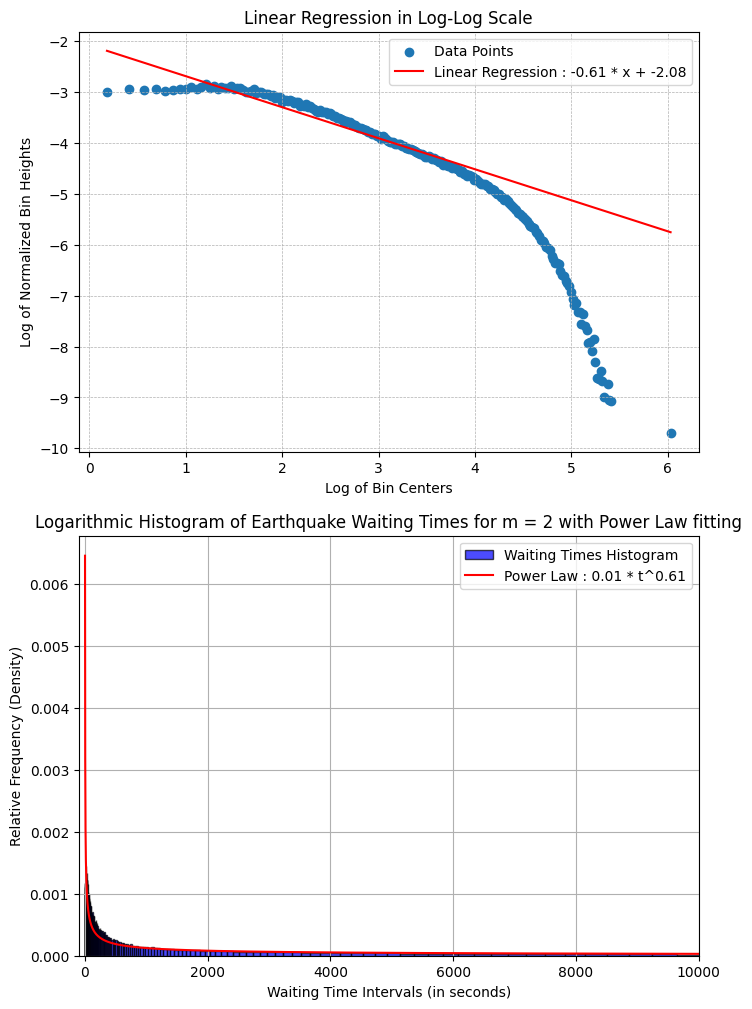

Chi-squared test statistic: 1.09
P-value: 1.0000
The model is a good fit for your data (p >= alpha)



        #################################################################################################################
                                                        FOR m = 3
        #################################################################################################################
        


Number of earthquakes selected for magnitude = 3 : 11923


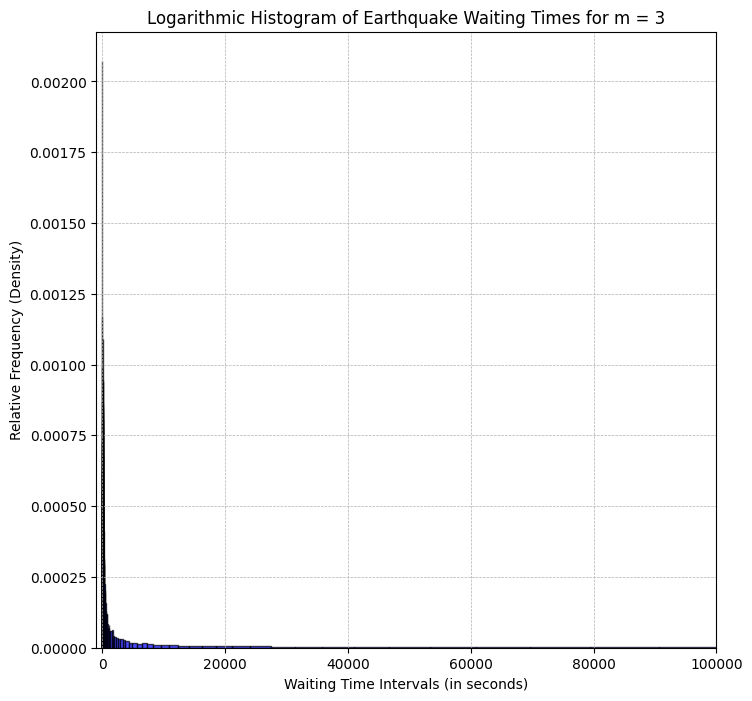

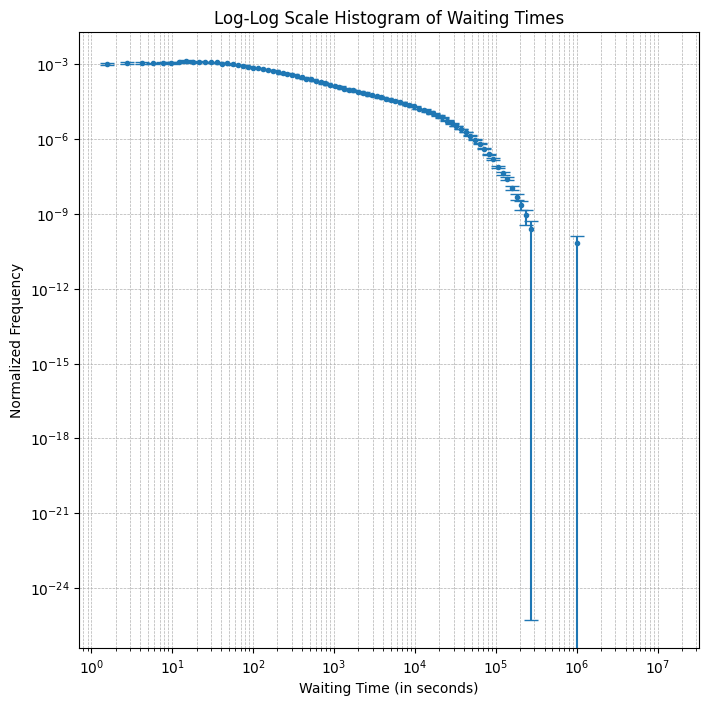

R^2: 0.71, with 80 data points remaining
R^2: 0.72, with 79 data points remaining
R^2: 0.74, with 78 data points remaining
R^2: 0.76, with 77 data points remaining
R^2: 0.78, with 76 data points remaining
R^2: 0.80, with 75 data points remaining
R^2: 0.81, with 74 data points remaining
R^2: 0.82, with 73 data points remaining
R^2: 0.84, with 72 data points remaining
R^2: 0.85, with 71 data points remaining
R^2: 0.86, with 70 data points remaining
R^2: 0.87, with 69 data points remaining
R^2: 0.87, with 68 data points remaining
R^2: 0.88, with 67 data points remaining
R^2: 0.88, with 66 data points remaining
R^2: 0.89, with 65 data points remaining
R^2: 0.89, with 64 data points remaining
R^2: 0.89, with 63 data points remaining
R^2: 0.89, with 62 data points remaining
R^2: 0.89, with 61 data points remaining
R^2: 0.89, with 60 data points remaining
R^2 is lower than previous value. Stopping removal of data points and returns to the previous data.

        Best-fit parameters:
        	

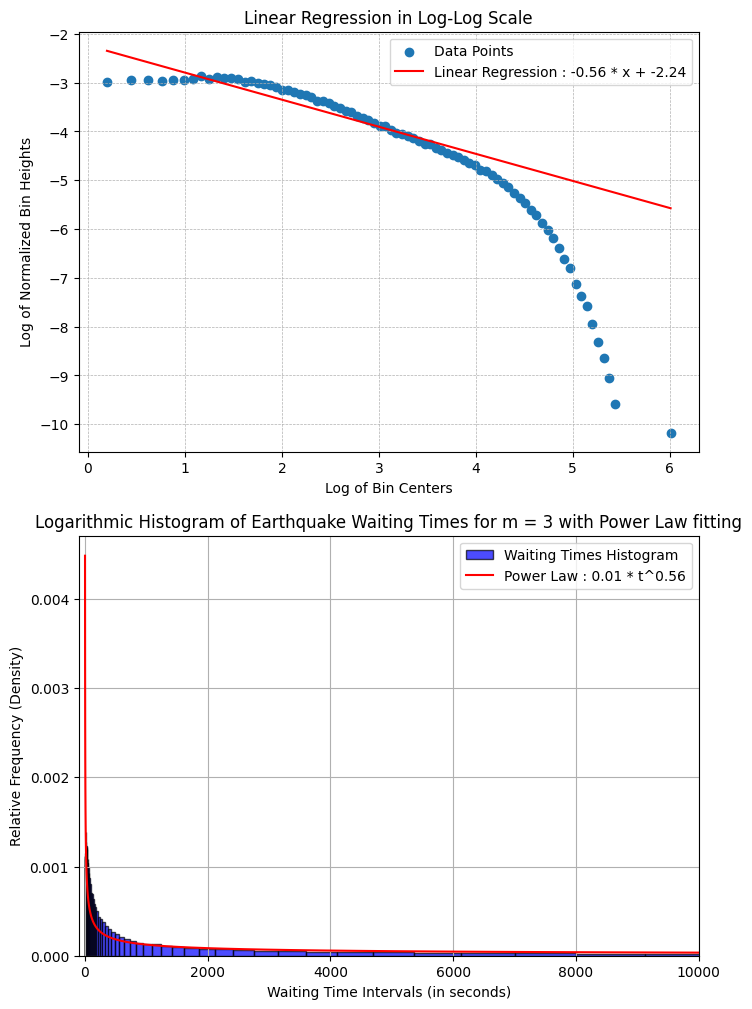

Chi-squared test statistic: 1.52
P-value: 1.0000
The model is a good fit for your data (p >= alpha)



        #################################################################################################################
                                                        FOR m = 4
        #################################################################################################################
        


Number of earthquakes selected for magnitude = 4 : 1133


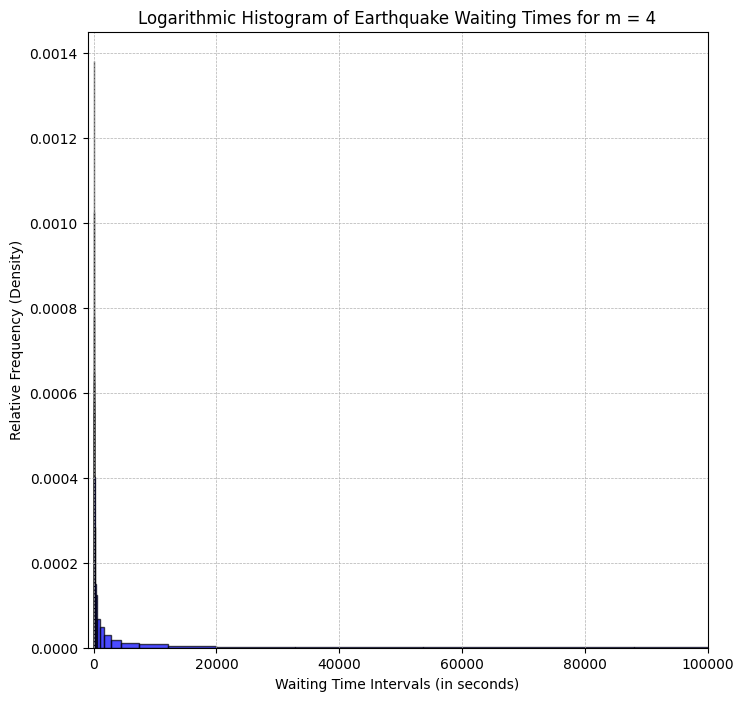

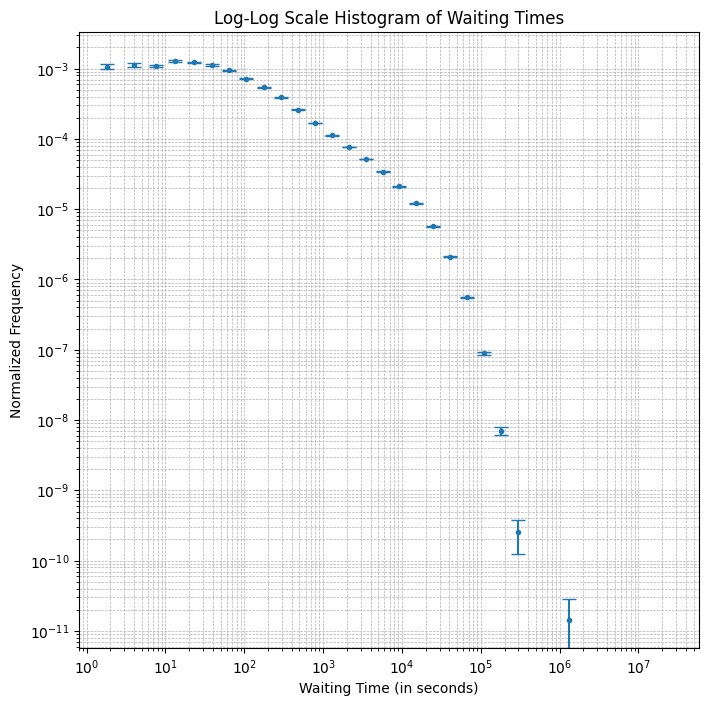

R^2: 0.65, with 25 data points remaining
R^2: 0.68, with 24 data points remaining
R^2: 0.75, with 23 data points remaining
R^2: 0.81, with 22 data points remaining
R^2: 0.84, with 21 data points remaining
R^2: 0.86, with 20 data points remaining
R^2: 0.87, with 19 data points remaining
R^2: 0.87, with 18 data points remaining
R^2 is lower than previous value. Stopping removal of data points and returns to the previous data.

        Best-fit parameters:
        	 - Slope       : -0.51
        	 - Intercept   : -2.38
        


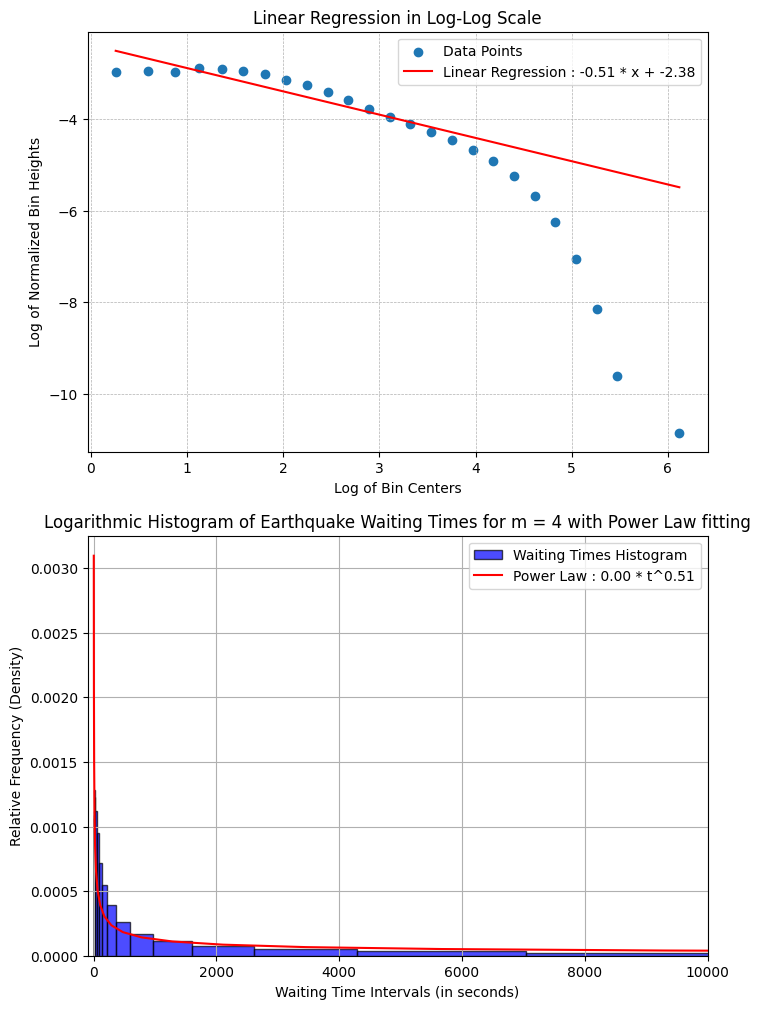

Chi-squared test statistic: 2.90
P-value: 1.0000
The model is a good fit for your data (p >= alpha)



        #################################################################################################################
                                                        FOR m = 5
        #################################################################################################################
        


Number of earthquakes selected for magnitude = 5 : 109


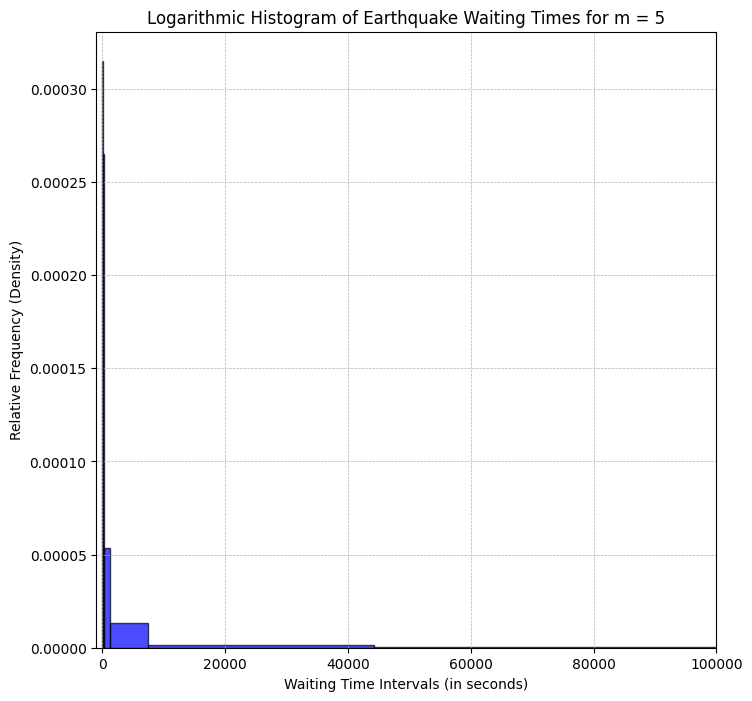

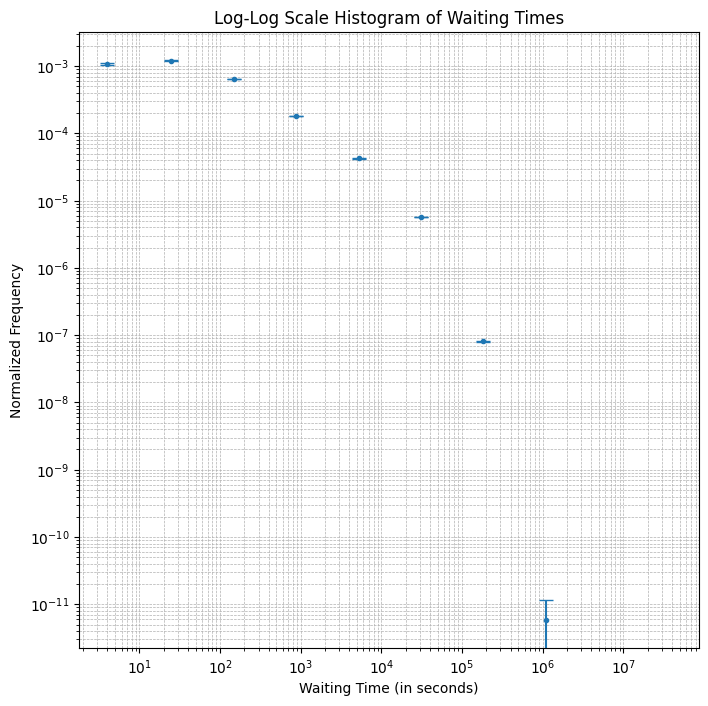

R^2: 0.61, with 8 data points remaining
R^2: 0.80, with 7 data points remaining
R^2: 0.88, with 6 data points remaining
R^2: 0.86, with 5 data points remaining
R^2 is lower than previous value. Stopping removal of data points and returns to the previous data.

        Best-fit parameters:
        	 - Slope       : -0.53
        	 - Intercept   : -2.34
        


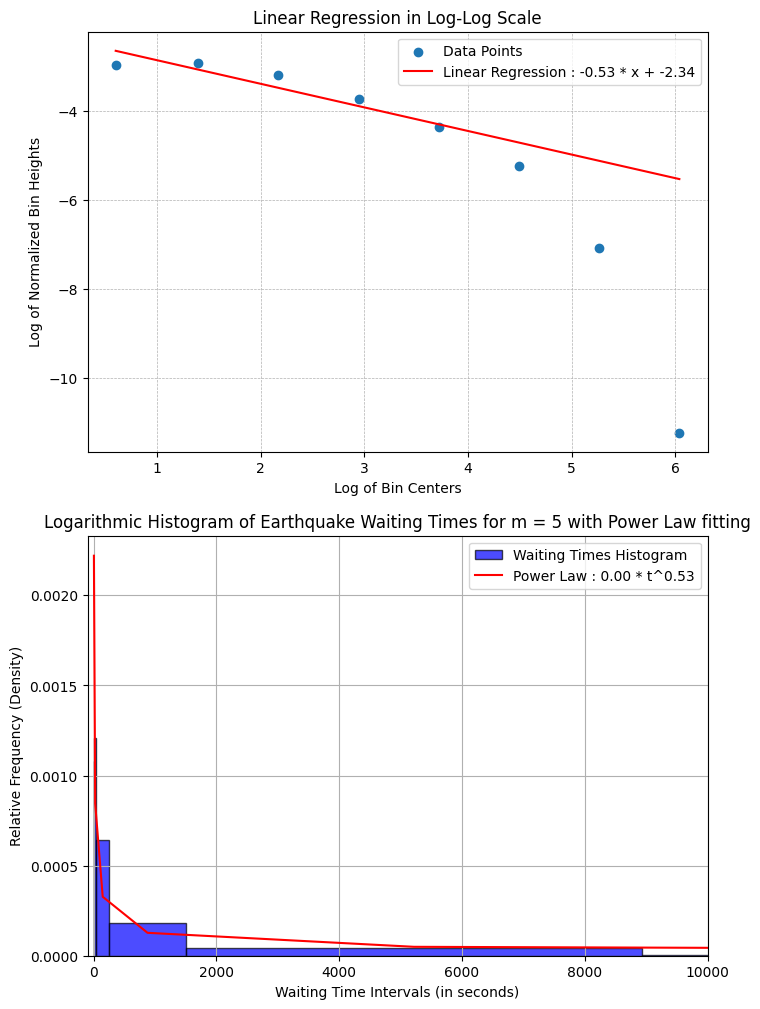

Chi-squared test statistic: 6.14
P-value: 0.4075
The model is a good fit for your data (p >= alpha)


In [36]:
process_earthquake_data(df, m)

------------------------------------------

3. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude $m$ or above. Make a clever choice for the bin sizes, and try several values of $m$. Fit the data with an appropriate function, if possible.

----------------------------------------------

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17312\379772392.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'Distance_m{m}'][1:] = calculate_distance(distance_x, distance_y, distance_z)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17312\379772392.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17312\379772392.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'Distance_m{m}'][1:] = calculate_distance(distance_x, distance_y, distance_z)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17312\379772392.py:11: RuntimeWarni

DataFrame with Distances (Magnitude >= 2):
        Event_index  Previous_event          Time  Magnitude        x  \
0                 0              -1  0.000000e+00       2.71 -2571956   
1                 1               0  3.650139e+04       2.12 -2363740   
2                 2               0  3.748828e+04       2.33 -2363746   
3                 3               0  4.798252e+04       2.57 -2475085   
4                 4               0  6.026857e+04       2.98 -2238642   
...             ...             ...           ...        ...      ...   
110266       110266              -1  9.304996e+08       2.60 -2668492   
110267       110267              -1  9.305115e+08       2.02 -2297480   
110268       110268              -1  9.305318e+08       2.00 -2404797   
110269       110269              -1  9.305363e+08       2.17 -2388375   
110270       110270              -1  9.305667e+08       3.27 -2579453   

              y        z  Distance_m2  
0      -4627162  3520602     0.000000  


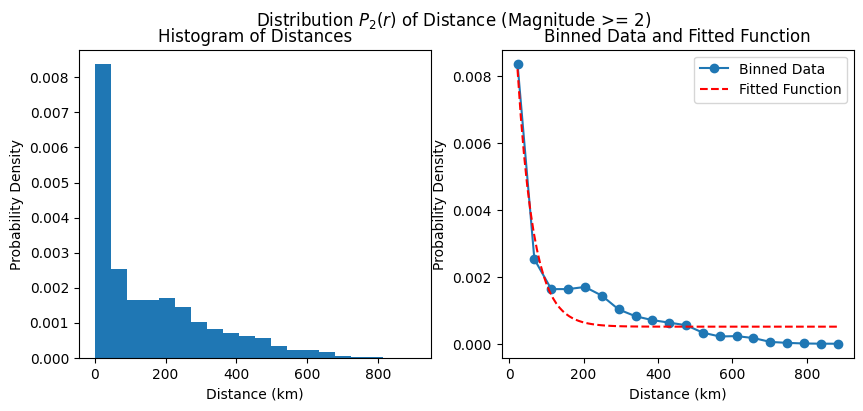

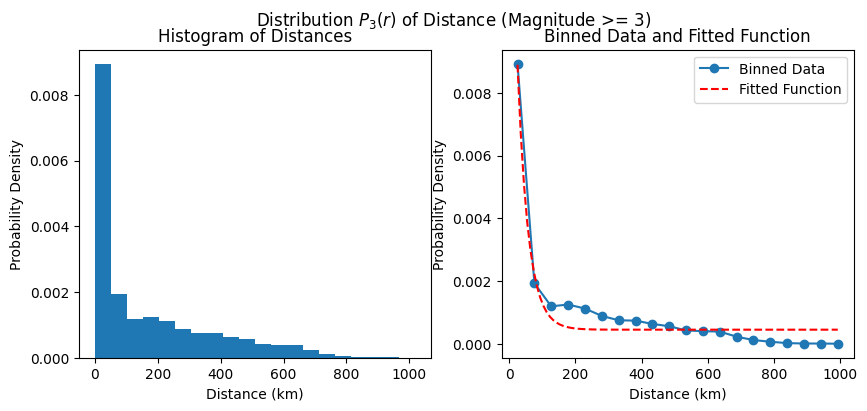

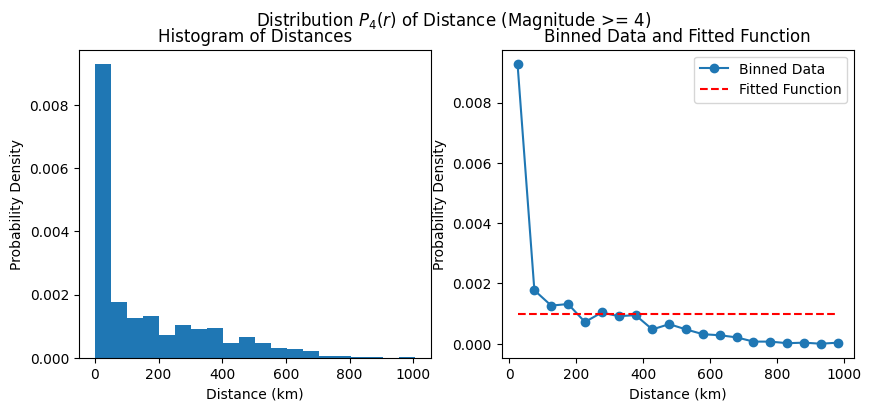

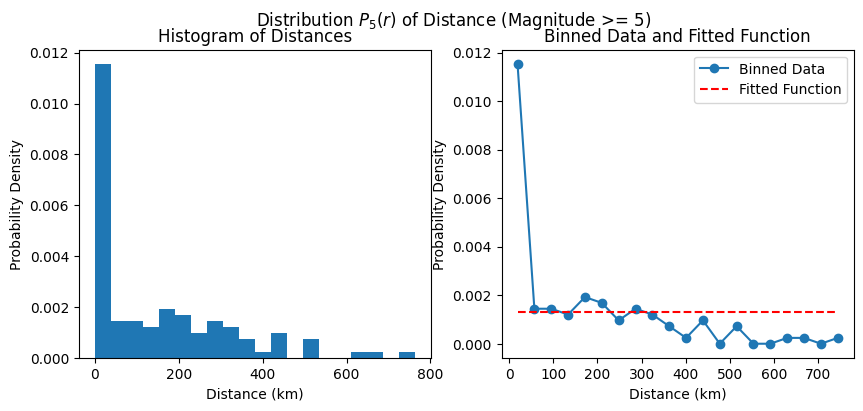

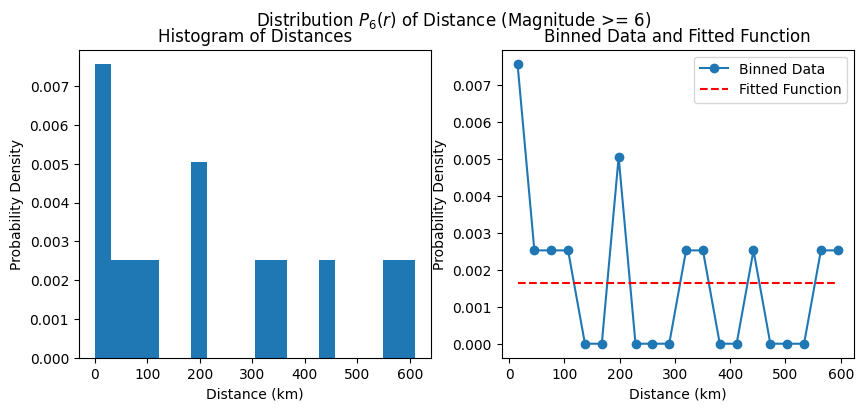

In [37]:
# Magnitude thresholds
magnitudes = np.array([2, 3, 4, 5, 6])

# Number of bins
bins = 20

def calculate_distance(distance_x, distance_y, distance_z):
    return np.sqrt((distance_x)**2 + (distance_y)**2 + (distance_z)**2) / 1000

def fit_function(x, a, b, c):
    return a * np.exp(-b * x) + c

for m in magnitudes:
    # Filter data based on magnitude threshold
    df_filtered = df[df['Magnitude'] >= m].dropna()

    # Calculate differences in coordinates to get distances
    distance_x = np.diff(df_filtered['x'])
    distance_y = np.diff(df_filtered['y'])
    distance_z = np.diff(df_filtered['z'])

    # Calculate 3D distances and add to DataFrame
    df_filtered[f'Distance_m{m}'] = np.zeros(df_filtered.shape[0])
    df_filtered[f'Distance_m{m}'][1:] = calculate_distance(distance_x, distance_y, distance_z)

    # Display DataFrame with calculated distances
    print(f"DataFrame with Distances (Magnitude >= {m}):\n{df_filtered}")

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'Distribution $P_{m}(r)$ of Distance (Magnitude >= {m})')

    # Subplot 1: Histogram
    plt.subplot(121)
    h, bins_edges, _ = plt.hist(df_filtered[f'Distance_m{m}'], bins=20, density=True)
    print("Heights:", h)
    print("Bins Edges:", bins_edges)
    plt.xlabel('Distance (km)')
    plt.ylabel('Probability Density')
    plt.title('Histogram of Distances')

    # Subplot 2: Binned Data and Fitted Function
    plt.subplot(122)
    bins_centers = (bins_edges[1:] + bins_edges[:-1]) / 2
    plt.plot(bins_centers, h, marker='o', label='Binned Data')

    # Fit the data using curve_fit
    popt, pcov = optimize.curve_fit(fit_function, bins_centers, h)

    # Plot the fitted function
    x_fit = np.linspace(bins_centers.min(), bins_centers.max(), 100)
    plt.plot(x_fit, fit_function(x_fit, *popt), 'r--', label='Fitted Function')

    # Print the fitted parameters
    print(f"Fitted Parameters (Magnitude >= {m}): a = {popt[0]}, b = {popt[1]}, c = {popt[2]}")

    plt.xlabel('Distance (km)')
    plt.ylabel('Probability Density')
    plt.title('Binned Data and Fitted Function')
    plt.legend()

plt.show()

We initially attempted to analyze seismic data using an exponential representation, but encountered challenges due to the wide range of magnitudes. The exponential approach did not effectively capture patterns and made visualization difficult. In fact, starting from the magnitude threshold of 4, we only observed a straight line.

To address this, we opted for a logarithmic representation. This choice is motivated by the logarithmic scale's ability to linearize exponential decay patterns, making trends more apparent. Additionally, it provides a clearer visualization of variances in magnitudes and distances, especially when dealing with data covering multiple orders of magnitude.

The decision to use logarithmic scales is based on their effectiveness in fitting certain models, reducing noise impact, and aligning with natural processes that often exhibit logarithmic or power-law distributions. This change allows for a more accurate representation of seismic patterns and facilitates a clearer interpretation of the dataset.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17312\3165157221.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'Distance_m{m}'][1:] = calculate_distance(distance_x, distance_y, distance_z)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17312\3165157221.py:17: RuntimeWarning: invalid value encountered in log10
  return a / np.log10(b * x + c)
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17312\3165157221.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

DataFrame with Distances (Magnitude >= 2):
        Event_index  Previous_event          Time  Magnitude        x  \
0                 0              -1  0.000000e+00       2.71 -2571956   
1                 1               0  3.650139e+04       2.12 -2363740   
2                 2               0  3.748828e+04       2.33 -2363746   
3                 3               0  4.798252e+04       2.57 -2475085   
4                 4               0  6.026857e+04       2.98 -2238642   
...             ...             ...           ...        ...      ...   
110266       110266              -1  9.304996e+08       2.60 -2668492   
110267       110267              -1  9.305115e+08       2.02 -2297480   
110268       110268              -1  9.305318e+08       2.00 -2404797   
110269       110269              -1  9.305363e+08       2.17 -2388375   
110270       110270              -1  9.305667e+08       3.27 -2579453   

              y        z  Distance_m2  
0      -4627162  3520602     0.000000  


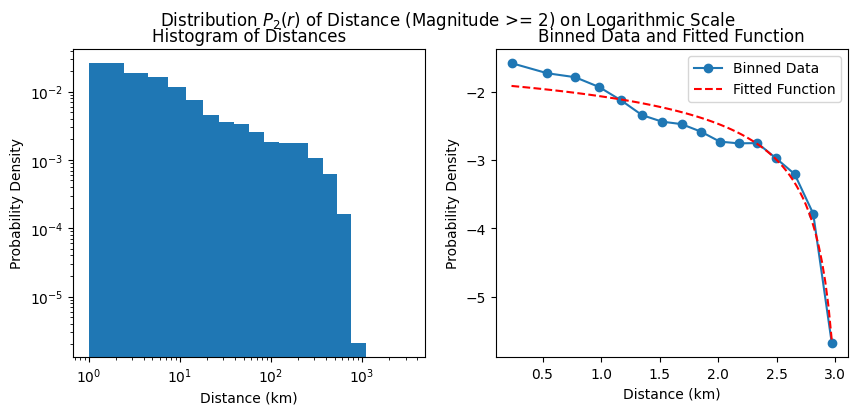

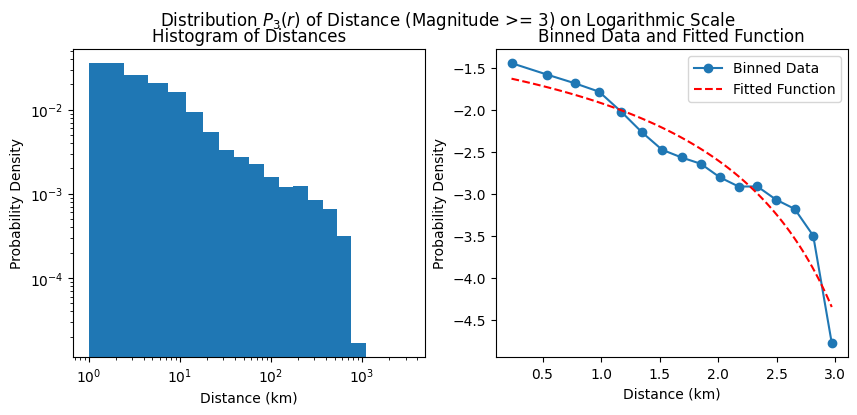

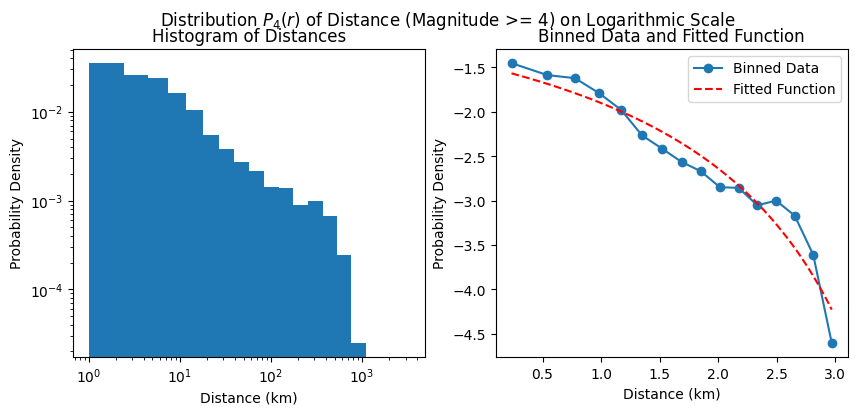

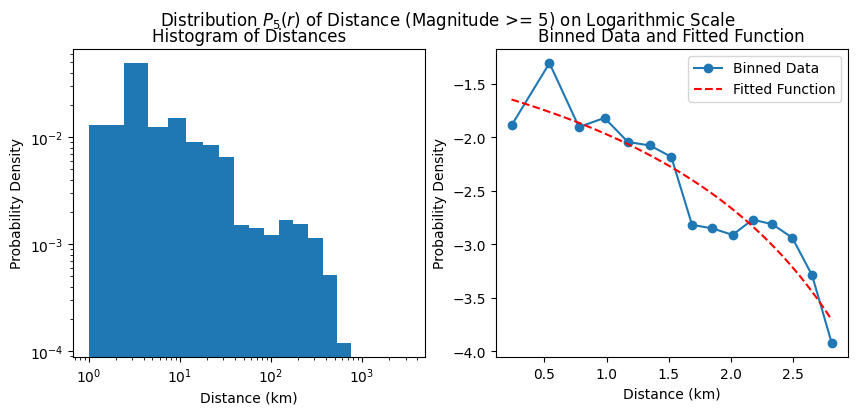

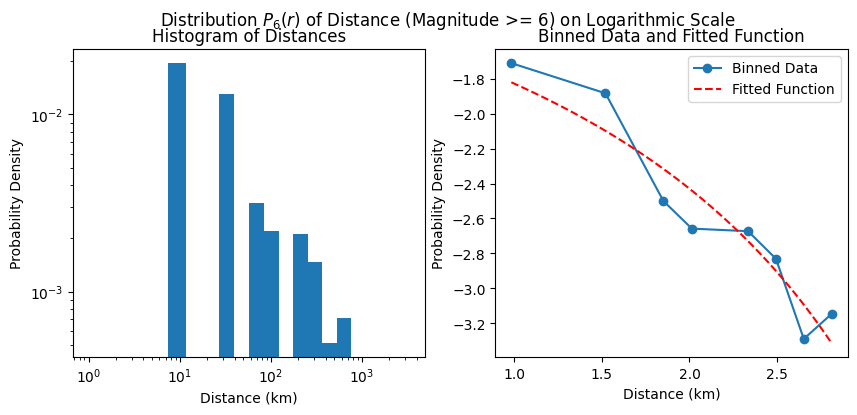

In [38]:
# Read the data
names = ['Event_index', 'Previous_event', 'Time', 'Magnitude', 'x', 'y', 'z']
df = pd.read_csv('SouthCalifornia-1982-2011.dat', sep=' ', names=names)
df = df.sort_values(by=['Time'])

# Magnitude thresholds
magnitudes = np.array([2, 3, 4, 5, 6])

# Array of bins edges: we observed that our previous bins_edges were between 0 and 10^3
bins = np.cumsum(np.logspace(0, 3, 20))

def calculate_distance(distance_x, distance_y, distance_z):
    return np.sqrt((distance_x)**2 + (distance_y)**2 + (distance_z)**2) / 1000

# Adjusted fit function for the opposite of the logarithm and shifted to the right
def fit_function(x, a, b, c, d):
    return a / np.log10(b * x + c)

for m in magnitudes:
    # Filter data based on magnitude threshold
    df_filtered = df[df['Magnitude'] >= m].dropna()

    # Calculate differences in coordinates to get distances
    distance_x = np.diff(df_filtered['x'])
    distance_y = np.diff(df_filtered['y'])
    distance_z = np.diff(df_filtered['z'])

    # Calculate 3D distances and add to DataFrame
    df_filtered[f'Distance_m{m}'] = np.zeros(df_filtered.shape[0])
    df_filtered[f'Distance_m{m}'][1:] = calculate_distance(distance_x, distance_y, distance_z)

    # Display DataFrame with calculated distances
    print(f"DataFrame with Distances (Magnitude >= {m}):\n{df_filtered}")

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'Distribution $P_{m}(r)$ of Distance (Magnitude >= {m}) on Logarithmic Scale')

    # Subplot 1: Histogram on Logarithmic Scale
    plt.subplot(121)
    h, bins_edges, _ = plt.hist(df_filtered[f'Distance_m{m}'], bins=bins, density=True)
    print("Heights:", h)
    print("Bins Edges:", bins_edges)
    plt.xlabel('Distance (km)')
    plt.ylabel('Probability Density')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Histogram of Distances')

    # Subplot 2: Binned Data and Fitted Function on Logarithmic Scale
    plt.subplot(122)
    bins_centers = (bins_edges[1:] + bins_edges[:-1]) / 2
    
    x = bins_centers[h > 0]
    y = h[h > 0]
    
    x = np.log10(x)
    y = np.log10(y)
    
    plt.plot(x, y, marker='o', label='Binned Data')

    # Fit the data using curve_fit
    popt, pcov = optimize.curve_fit(fit_function, x, y)

    # Plot the fitted function
    x_fit = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_fit, fit_function(x_fit, *popt), 'r--', label='Fitted Function')

    # Print the fitted parameters
    print(f"Fitted Parameters (Magnitude >= {m}): a = {popt[0]}, b = {popt[1]}, c = {popt[2]}")

    plt.xlabel('Distance (km)')
    plt.ylabel('Probability Density')
    plt.title('Binned Data and Fitted Function')
    plt.legend()

plt.show()

In this analysis, we addressed the objective of computing the distribution $P_m(r)$ of distances between consecutive earthquakes in South California, considering various magnitude thresholds. The dataset, `SouthCalifornia-1982-2011.dat`, containing earthquake information, was initially loaded and sorted based on time. We applied magnitude thresholds (2, 3, 4, 5, 6) to filter earthquakes, and for each magnitude threshold, we calculated the 3D distances between consecutive events.

Initially, an exponential fit function $a⋅exp(−b⋅x)+c$ was employed to model the data. However, due to visibility issues, we later switched to a logarithmic representation. The histogram, binned data, and the fitted function were presented on a logarithmic scale for enhanced clarity. The fit function was adjusted to $\frac{a}{log(bx + c)}$ to better capture the characteristics of the decay observed in the data.

Throughout the process, we included detailed print statements, DataFrame displays, and labeled plots to facilitate understanding. The first code utilized a straightforward exponential fit, while the second code incorporated logarithmic scales to improve visualization. The iterative approach allowed us to adapt the analysis to better suit the nature of the earthquake distribution in the region.

-------------------

The analysis of earthquake distribution in South California, as depicted by the second code, reveals intriguing patterns when considering various magnitude thresholds. The histograms, presented on a logarithmic scale, offer insights into the spatial relationships between consecutive earthquakes.

Observing the binned data and the fitted function $\frac{a}{log(bx + c)}$, it becomes apparent that the probability density of distances decays in a manner inversely proportional to the logarithm of the distance. This suggests a tendency for earthquakes to be more clustered at shorter distances and become less frequent as the distance between events increases. The fitted parameters $a, b, c$ provide quantitative information about the decay characteristics.

Furthermore, the logarithmic representation allows for a clearer visualization of the distribution, particularly highlighting the behavior in the tail of the distribution where earthquakes occur at larger distances. This insight is valuable for understanding the spatial dynamics of seismic events in South California and contributes to a more comprehensive characterization of earthquake patterns in the region.

----------------------------------------

4. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. In this case, if the following event is farther than $R$, skip the $t$ and go to the next pair.

----------------------------------------------

In log scale, distribution is more relevant:
Mean value of waiting times (m = 1.0 , r=10000) = 2773
Mean value of waiting times (m = 1.0 , r=50000) = 3413
Mean value of waiting times (m = 1.0 , r=250000) = 6691
Mean value of waiting times (m = 1.0 , r=1000000) = 8439


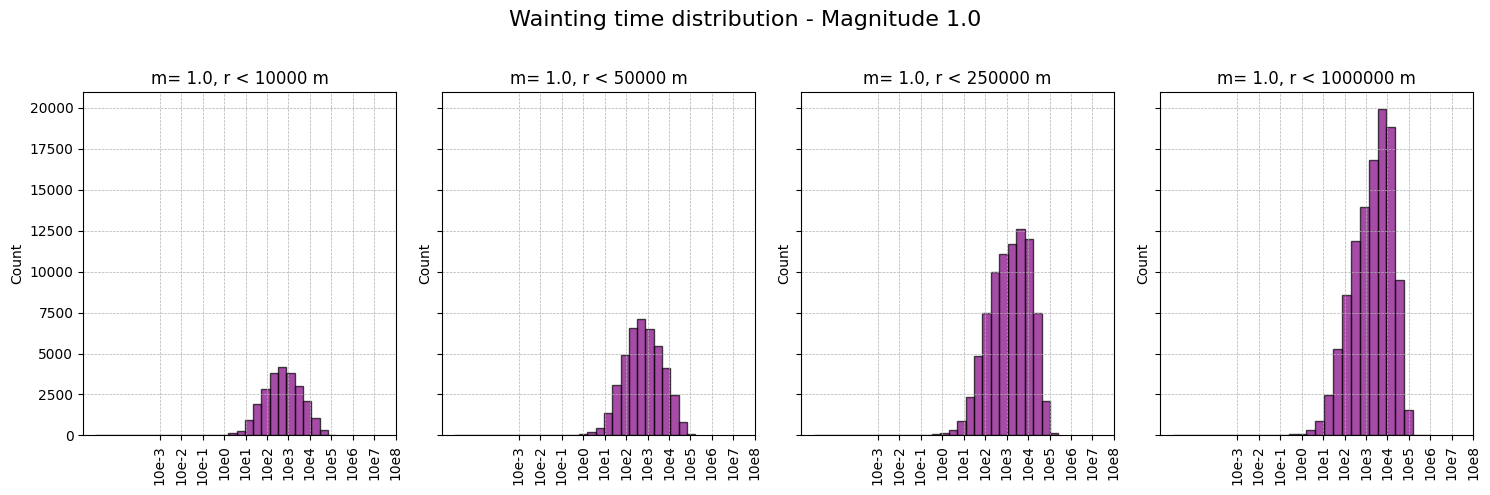

Mean value of waiting times (m = 2.5 , r=10000) = 7439
Mean value of waiting times (m = 2.5 , r=50000) = 8978
Mean value of waiting times (m = 2.5 , r=250000) = 18138
Mean value of waiting times (m = 2.5 , r=1000000) = 24735


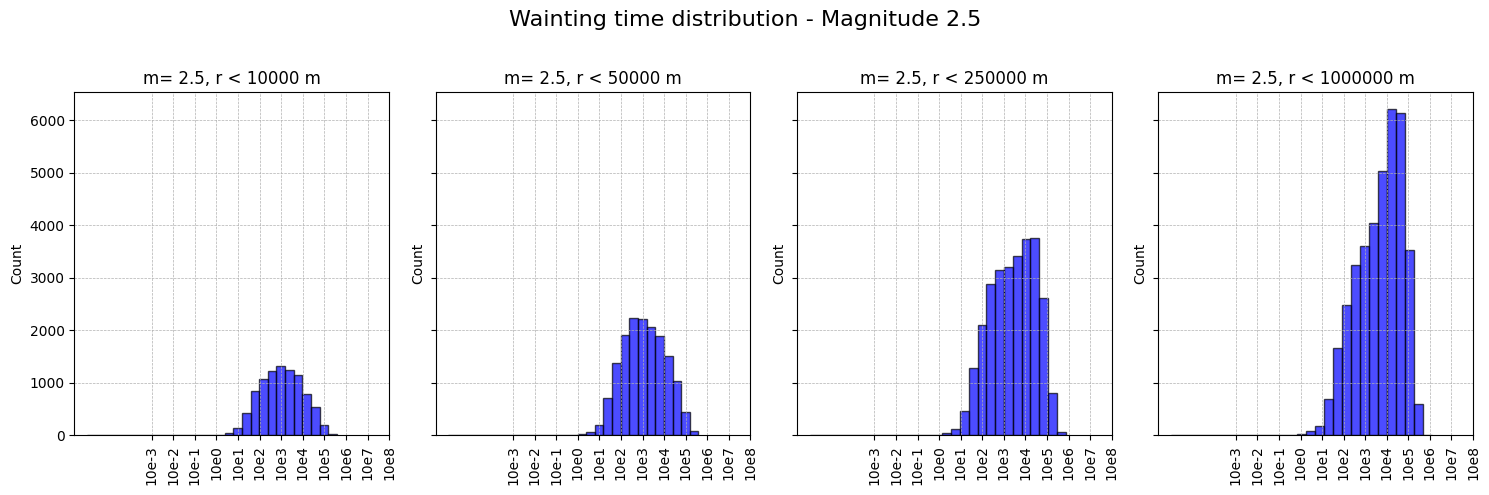

Mean value of waiting times (m = 3.0 , r=10000) = 20814
Mean value of waiting times (m = 3.0 , r=50000) = 26555
Mean value of waiting times (m = 3.0 , r=250000) = 55009
Mean value of waiting times (m = 3.0 , r=1000000) = 81141


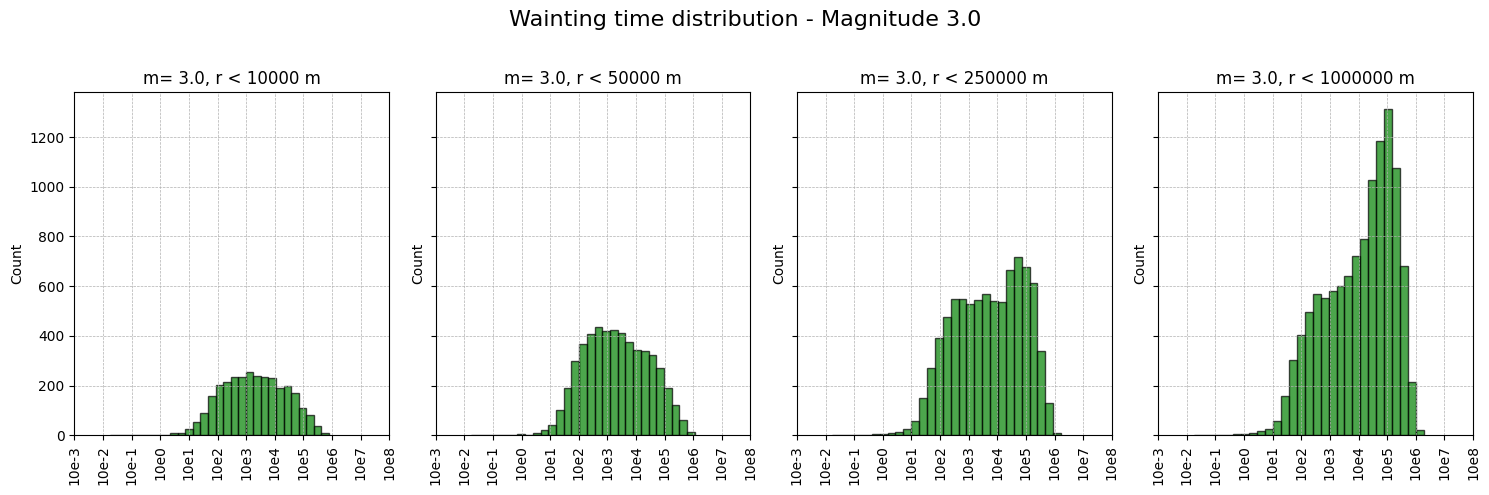

Mean value of waiting times (m = 3.5 , r=10000) = 49482
Mean value of waiting times (m = 3.5 , r=50000) = 72149
Mean value of waiting times (m = 3.5 , r=250000) = 172450
Mean value of waiting times (m = 3.5 , r=1000000) = 262744


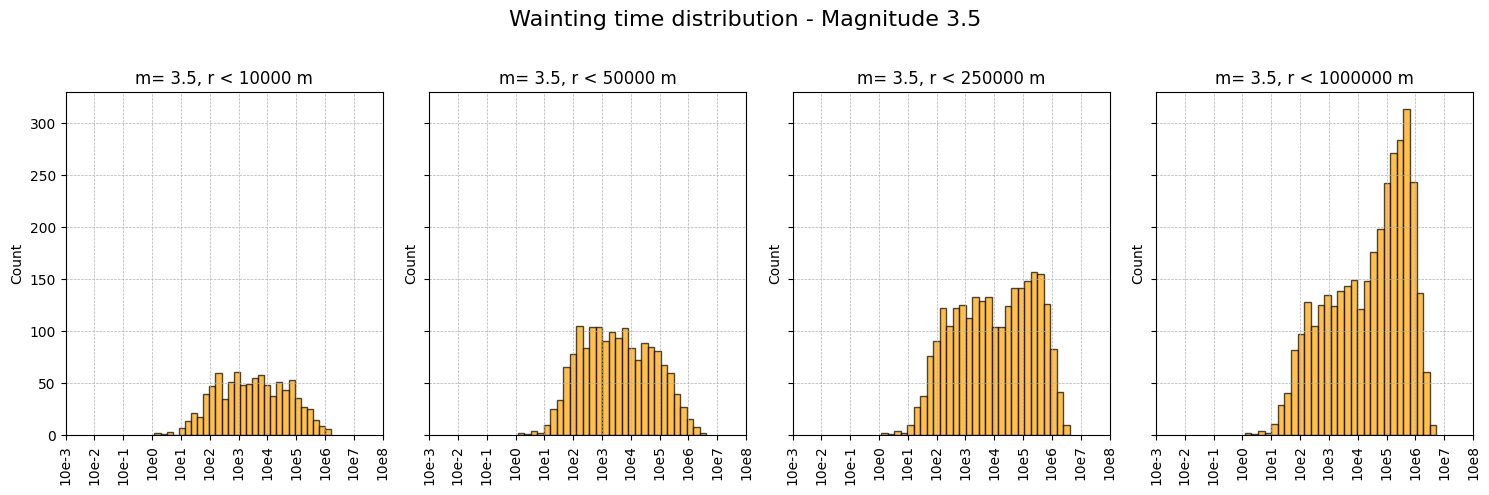

Mean value of waiting times (m = 4.0 , r=10000) = 101569
Mean value of waiting times (m = 4.0 , r=50000) = 196473
Mean value of waiting times (m = 4.0 , r=250000) = 517756
Mean value of waiting times (m = 4.0 , r=1000000) = 840012


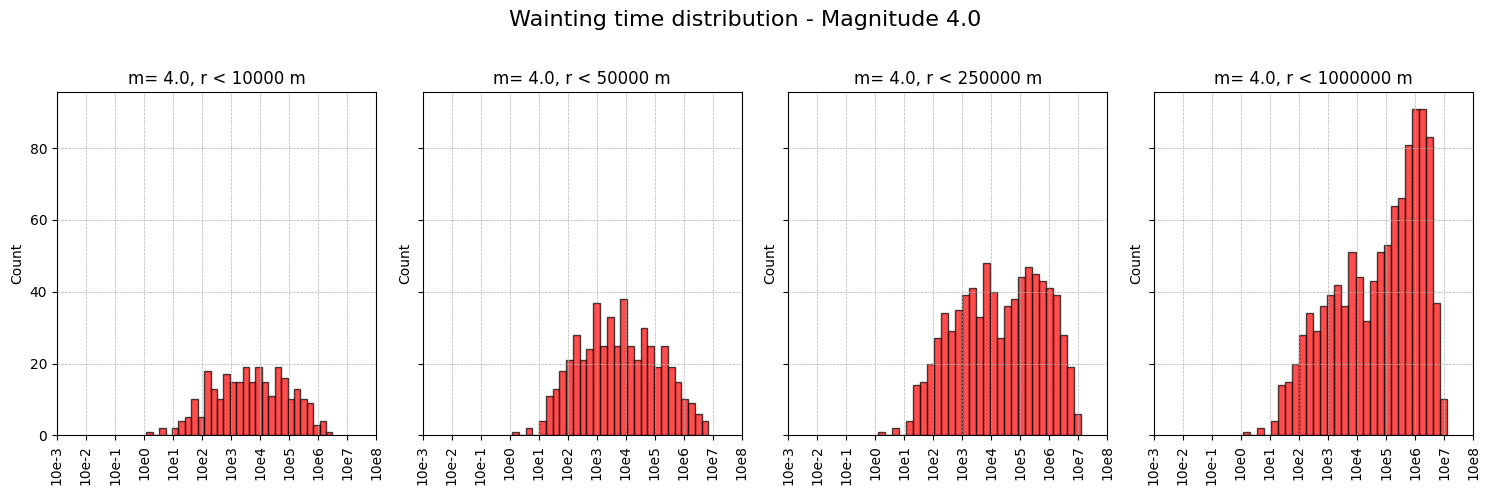

In [39]:
#filter dataset to keep only magnitude > m
def filter_dataset(df,min_magnitude=4):
    filtered_df = df.query('Magnitude > @min_magnitude')
    return filtered_df

#calculate distance between 2 earthquakes
def calculate_distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

#calculate waiting time between two earthquakes
def calculate_interquake_times(df, max_distance):
    df_copy = df.copy()  
    df_copy['Interquake_Time'] = df_copy['Time'].diff()

    interquake_times = []

    for i in range(1, len(df_copy)):
        distance = calculate_distance(df_copy.iloc[i, df_copy.columns.get_loc('x')],
                                       df_copy.iloc[i, df_copy.columns.get_loc('y')],
                                       df_copy.iloc[i, df_copy.columns.get_loc('z')],
                                       df_copy.iloc[i-1, df_copy.columns.get_loc('x')],
                                       df_copy.iloc[i-1, df_copy.columns.get_loc('y')],
                                       df_copy.iloc[i-1, df_copy.columns.get_loc('z')])
        if distance <= max_distance:
            interquake_times.append(df_copy.iloc[i, df_copy.columns.get_loc('Interquake_Time')])

    if interquake_times:
        interquake_df = pd.DataFrame({'Interquake_Time': interquake_times})
        return interquake_df
    else:
        print("No interquake times found within the specified distance")
        return pd.DataFrame() 

    #plot waiting time distribution
def plot_interquake_distribution(ax, interquake_df, magnitude, distance):
    # delete NaN
    interquake_time = interquake_df['Interquake_Time'].dropna()

    # set to log scale
    min_value = 1e-6
    min_interquake_time = max(interquake_time.min(), min_value)
    log_bins = np.logspace(np.log10(min_interquake_time), np.log10(interquake_time.max()), 30)
    counts, bins, _ = ax.hist(interquake_time, bins=log_bins, alpha=0.7, edgecolor='black', color=color)
    ax.set_xscale('log')

    ax.set_xticks([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000])  # Adjust these values based on your actual data
    ax.set_xticklabels(['10e-3', '10e-2', '10e-1', '10e0', '10e1', '10e2', '10e3', '10e4', '10e5', '10e6', '10e7', '10e8'])  # Customize labels based on your actual data
    plt.setp(ax.get_xticklabels(), rotation='vertical')

    ax.set_title(f'm= {magnitude}, r < {distance} m')
    ax.set_ylabel('Count')

magnitudes = np.array([1, 2.5, 3, 3.5, 4]) 
distances = np.array([10000, 50000, 250000, 1000000])
df = load_dataset()
print("In log scale, distribution is more relevant:")
colors = ['purple', 'blue', 'green', 'orange', 'red']

#plot every distribution
for i, magnitude in enumerate(magnitudes):
    fig, axes = plt.subplots(1, len(distances), figsize=(15, 5), sharey=True)
    for j, distance in enumerate(distances):
        filtered_df = filter_dataset(df, min_magnitude=magnitude)
        interquake_df = calculate_interquake_times(filtered_df, max_distance=distance)
        print(f"Mean value of waiting times (m = {magnitude} , r={distance}) = {round(interquake_df['Interquake_Time'].mean())}")
        color = colors[i]
        plot_interquake_distribution(axes[j], interquake_df, magnitude, distance)
        axes[j].grid(True, which='both', linestyle='--', linewidth=0.5)
        
    fig.suptitle(f'Wainting time distribution - Magnitude {magnitude}', fontsize=16 )
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()



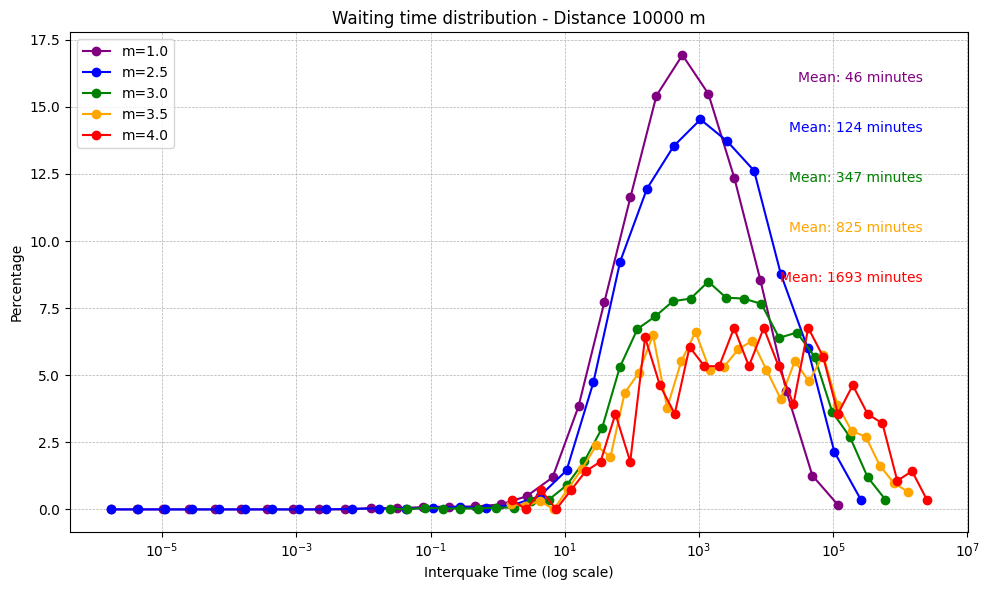

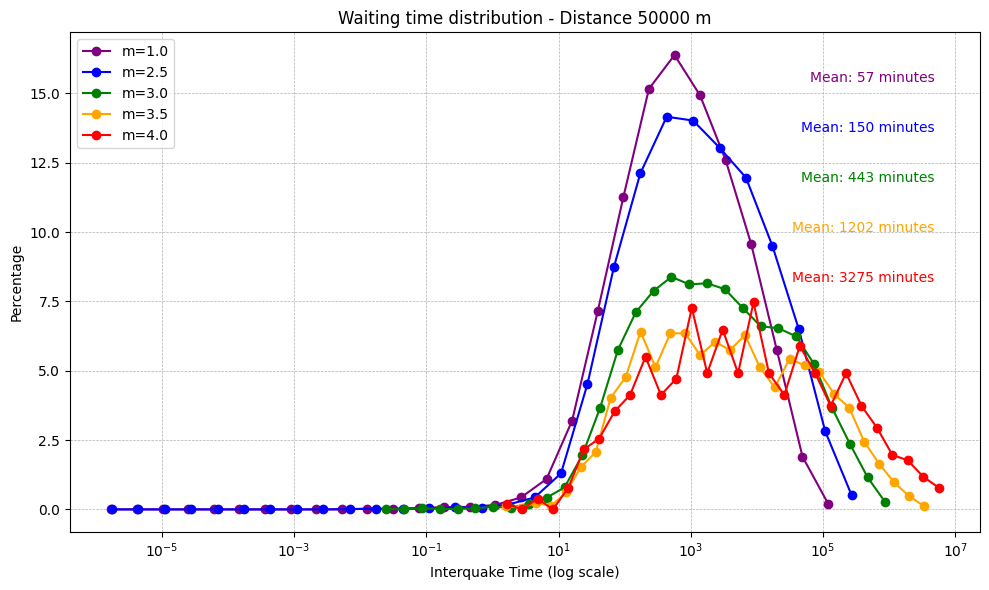

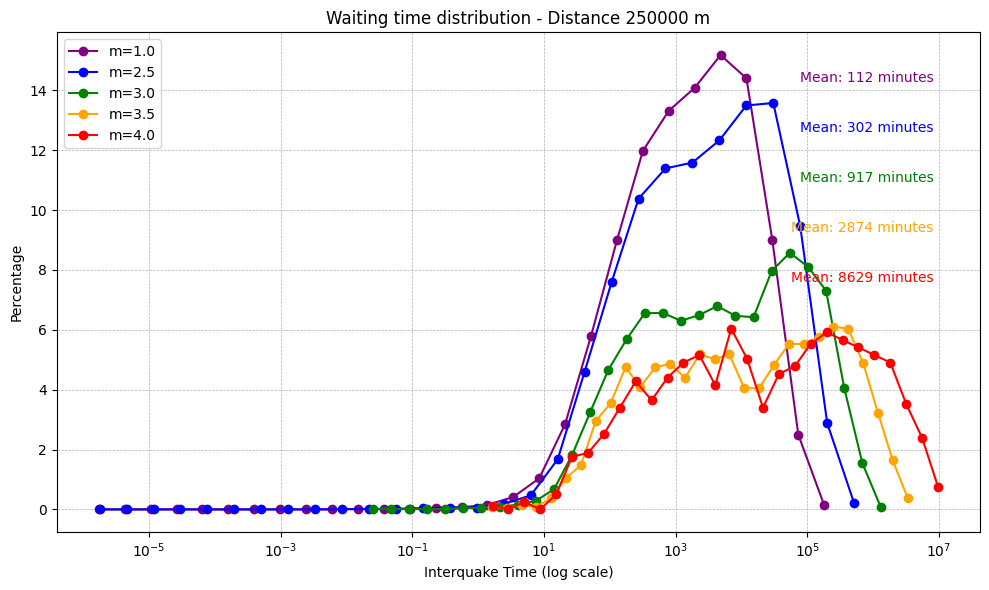

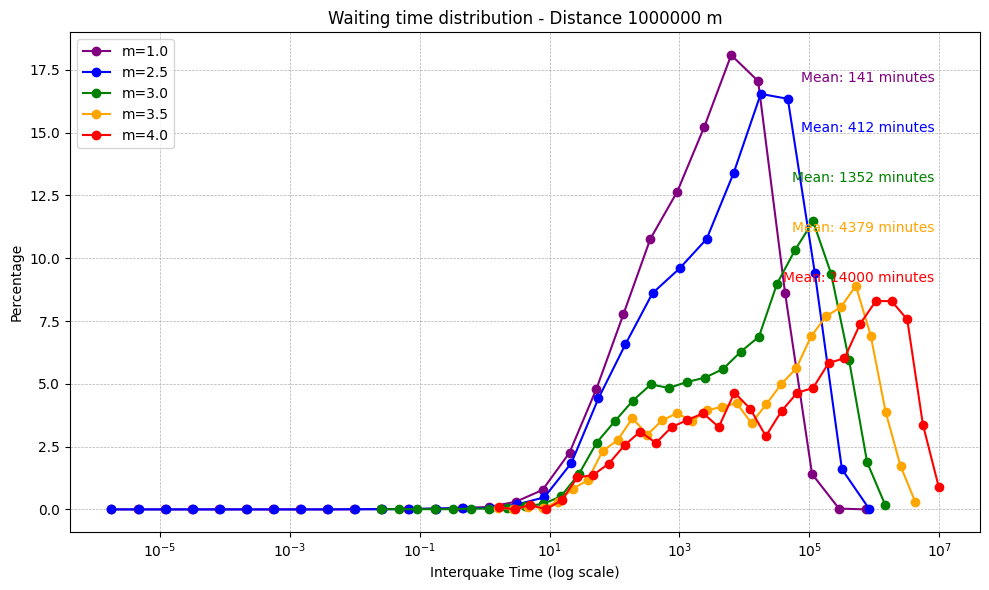

In [40]:
colors = ['purple', 'blue', 'green', 'orange', 'red']
#plot distributions with distances
def plot_interquake_distribution_by_distances(ax, interquake_df, magnitude, distance,color):
    interquake_time = interquake_df['Interquake_Time'].dropna()

    min_value = 1e-6
    min_interquake_time = max(interquake_time.min(), min_value)
    log_bins = np.logspace(np.log10(min_interquake_time), np.log10(interquake_time.max()), 30)

    counts, bins = np.histogram(interquake_time, bins=log_bins)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    total_counts = np.sum(counts)
    percentages = counts / total_counts * 100

    ax.plot(bin_centers, percentages, label=f'm={magnitude}', marker='o', color=color)


#plot the graph distributions
for j, distance in enumerate(distances):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, magnitude in enumerate(magnitudes):
        filtered_df = filter_dataset(df, min_magnitude=magnitude)
        interquake_df = calculate_interquake_times(filtered_df, max_distance=distance)

        color = colors[i % len(colors)]  # color
        plot_interquake_distribution_by_distances(ax, interquake_df, magnitude, distance, colors[i])

        # mean
        mean_interquake_time = interquake_df['Interquake_Time'].mean()
        ax.text(0.95, 0.9 - i * 0.1, f'Mean: {round(mean_interquake_time/60)} minutes', transform=ax.transAxes, color=color, ha='right')

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_title(f'Waiting time distribution - Distance {distance} m')
    ax.set_xlabel('Interquake Time (log scale)')
    ax.set_ylabel('Percentage')
    ax.set_xscale('log') 
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()



These distributions shows that the waiting time between two earthquakes with magnitude > m increase if we increase m, which is logical because earthquakes get rarer.

If we increase the distance R allowed to take in account, the waiting time also increase, which can be explain by triggered earthquakes. An earthquake can trigger another one, which will come close to the previous and faster than a random earthquake.

Almost the same distribution can be observed in log scale between different magnitudes and distances, showing that we can predict when and where will arrive the next earthquake depending on magnitude. However scale is huge and prediction cannot be accurate only with this modele 

For a radius of 1000 km around the first earthquake, the mean time for seeing an earthquake of magnitude > 4 is 14000 minutes, so around 10 days. However, this number doesn't represent really well the reality, as a lot of violent earthquakes happens in a small interval of time and then the next one happen few months later.

----------------------------------------

5. Comment whether there is a scaling law from the analysis of the previous points. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

-------------------------------------------

### For $P_m(t)$

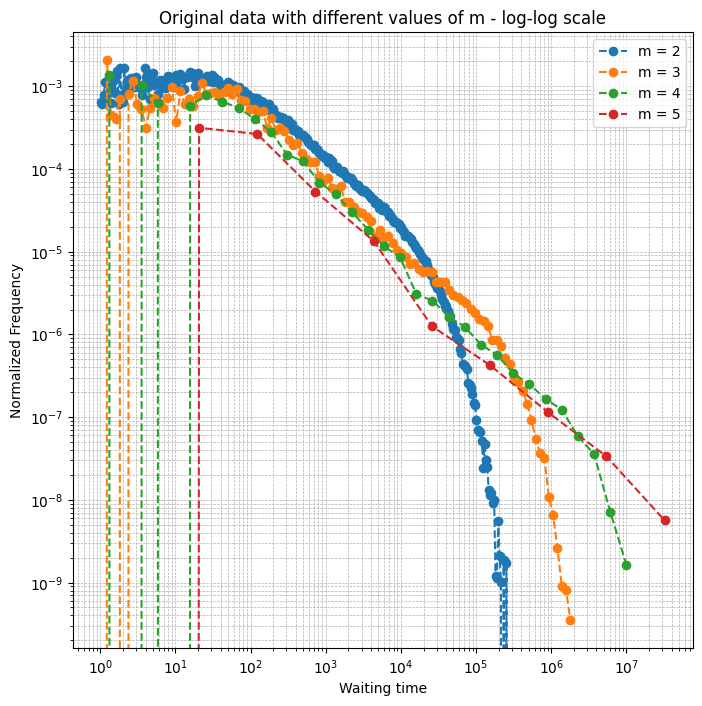

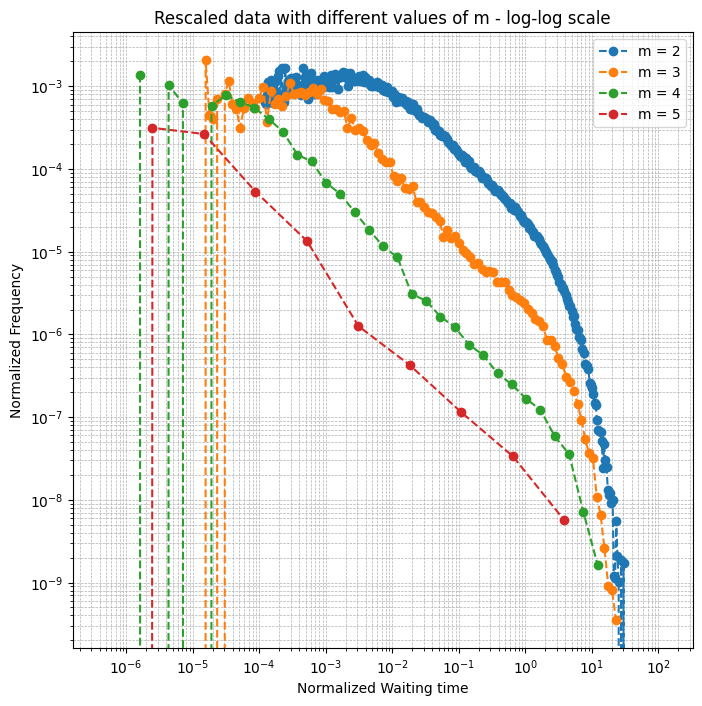

In [22]:
df = load_dataset()
m = [i for i in range(2, 6)] 

def dataframe_process_without_print(df, magnitude_threshold):
    """
    Filters the earthquakes in the DataFrame 'df' for those with a magnitude of 'magnitude_threshold' or higher,
    and calculates the waiting times (intervals) between consecutive events.

    :param df: DataFrame containing the earthquake data.
    :param magnitude_threshold: Minimum magnitude of earthquakes to consider.
    :return: DataFrame filtered with calculated waiting times.
    """
    # Filter earthquakes with magnitude magnitude_threshold or higher
    df_filtered = df[df['Magnitude'] >= magnitude_threshold].copy()
    # Calculate the waiting time as the interval between events
    df_filtered['Waiting Time'] = df_filtered['Time'].diff(-1).abs()
    # Remove missing values, if any
    df_filtered.dropna(inplace=True)
    return df_filtered

# --------------------------------------------------
# Original data

fig1, ax1 = plt.subplots(figsize=(8, 8))

for magnitude in m: 
    df_m = dataframe_process_without_print(df, magnitude)
    df_m = df_m[['Waiting Time']]

    end = np.log10(df_m['Waiting Time'].max())   # Compute log10 of the maximum waiting time
    bin_edges = int(np.sqrt(df_m.shape[0])) + 1  # Determine the number of bins for the histogram
    edges = np.logspace(0, end, bin_edges)       # Create logarithmically spaced bins

    # Calculate histogram using numpy instead of plotting directly with plt.hist
    hist, bins = np.histogram(df_m['Waiting Time'], bins=edges, density=True)
    
    # Calculate the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax1.plot(bin_centers, hist, '--o', label="m = " + str(magnitude))

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_title('Original data with different values of m - log-log scale')
ax1.set_xlabel('Waiting time')
ax1.set_ylabel('Normalized Frequency')
ax1.legend()
ax1.grid(True, which="both", ls="--", linewidth=0.5)

# --------------------------------------------------
# Rescaled data

fig2, ax2 = plt.subplots(figsize=(8, 8))

for magnitude in m: 
    df_m = dataframe_process_without_print(df, magnitude)
    df_m = df_m[['Waiting Time']]

    end = np.log10(df_m['Waiting Time'].max())   # Compute log10 of the maximum waiting time
    bin_edges = int(np.sqrt(df_m.shape[0])) + 1  # Determine the number of bins for the histogram
    edges = np.logspace(0, end, bin_edges)       # Create logarithmically spaced bins

    # Calculate histogram using numpy instead of plotting directly with plt.hist
    hist, bins = np.histogram(df_m['Waiting Time'], bins=edges, density=True)
    
    # Calculate the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Normalize waiting time for the second graph
    bin_centers /= df_m['Waiting Time'].mean()

    ax2.plot(bin_centers, hist, '--o', label="m = " + str(magnitude))

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_title('Rescaled data with different values of m - log-log scale')
ax2.set_xlabel('Normalized Waiting time')
ax2.set_ylabel('Normalized Frequency')
ax2.legend()
ax2.grid(True, which="both", ls="--", linewidth=0.5)

# --------------------------------------------------

plt.show(fig1)
plt.show(fig2)
